## Introduction to Survival Analysis

### Purpose
This notebook marks the beginning of the survival analysis phase, following the Exploratory Data Analysis (EDA) conducted in the previous notebook.

### Context
- The EDA was completed and saved, providing a foundation for this analysis.

### Focus
- The primary focus is to explore customer churn using survival analysis techniques, including:
  - **Kaplan-Meier survival curves** to visualize time-to-churn.
  - **Survival modeling** (e.g., Cox proportional hazards model) to identify key influencing factors.

### Objectives
- Build on insights from tenure, contract type, payment methods, and service features uncovered in the EDA.
- Develop actionable strategies to enhance customer loyalty and reduce churn risk.

## Loading Libraries

In [778]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines.statistics import logrank_test, proportional_hazard_test
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from patsy import dmatrix
from sksurv.datasets import get_x_y
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sklearn.inspection import permutation_importance

from lifelines import CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter, WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis

import joblib
import warnings
warnings.filterwarnings('ignore')

## Loading data

In [331]:
df = pd.read_csv('Cleaned_data.csv')
df = df.drop('Unnamed: 0', axis=1)

## Data overview

In [333]:
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns}")
print("Data Preview")
display(df.head())

Shape: (7043, 18)
Columns: Index(['customerID', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'Churn',
       'tenure_group'],
      dtype='object')
Data Preview


,customerID,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,tenure_group
0,7590-VHVEG,0,Yes,No,1,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,0,0-6 months
1,5575-GNVDE,0,No,No,34,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,0,25-48 months
2,3668-QPYBK,0,No,No,2,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,1,0-6 months
3,7795-CFOCW,0,No,No,45,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,0,25-48 months
4,9237-HQITU,0,No,No,2,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,1,0-6 months


## Create duration and event columns

In [335]:
# Duration = tenure
df['duration'] = df['tenure'].astype(float)

# Event = 1 if customer churned, 0 if still active
df['event'] = (df['Churn'] == 1).astype(int)

# Sanity check
print(df[['tenure', 'Churn', 'duration', 'event']].head(10))

# Quick check of event counts
print("\nEvent distribution:")
print(df['event'].value_counts())

   tenure  Churn  duration  event
0       1      0       1.0      0
1      34      0      34.0      0
2       2      1       2.0      1
3      45      0      45.0      0
4       2      1       2.0      1
5       8      1       8.0      1
6      22      0      22.0      0
7      10      0      10.0      0
8      28      1      28.0      1
9      62      0      62.0      0

Event distribution:
event
0    5174
1    1869
Name: count, dtype: int64


## Defining Duration and Event

For survival analysis, I created two key variables:

- **`duration`** - taken directly from `tenure`, representing how long each customer has been with the company (in months).  
- **`event`** - binary indicator: `1` if the customer churned, `0` if they are still active (right-censored).

### Insight
This setup allows the survival model to use **information from both churners and non-churners**:  
- Churners contribute observed event times.  
- Non-churners contribute censored lifetimes (we know they survived at least up to their tenure).  

This way, the model captures the **true distribution of customer lifetimes**, instead of learning only from those who churned.

## Missing Check

In [338]:
df.isna().sum()

customerID          0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
Churn               0
tenure_group        0
duration            0
event               0
dtype: int64

- **Data is clean.**

## Count Events and Censored Data
- `Censored` means the customers who are still active.

In [341]:
# Get the counts for events (1) and censored (0)
event_counts = df['event'].value_counts()
print("Event and Censored Data Counts:")
print(event_counts)

# Calculate proportions
total_customers = len(df)
event_proportion = event_counts.get(1, 0) / total_customers
censored_proportion = event_counts.get(0, 0) / total_customers

print(f"\nProportion of Events (Churned): {event_proportion:.2f}")
print(f"Proportion of Censored (Active): {censored_proportion:.2f}")

Event and Censored Data Counts:
event
0    5174
1    1869
Name: count, dtype: int64

Proportion of Events (Churned): 0.27
Proportion of Censored (Active): 0.73


In [342]:
event_df = df[df['event'] == 1].copy()
censored_df = df[df['event'] == 0].copy()

print("Median Duration of Event (Churned)", event_df['duration'].median(),'months')
print("Median Duration of Censored (Active)", censored_df['duration'].median(),'months')

Median Duration of Event (Churned) 10.0 months
Median Duration of Censored (Active) 38.0 months


## Insights from Censoring and Duration Analysis

### Dataset Composition
- The dataset consists of **73% censored observations (active customers)** and **27% events (churned customers)**.
- This well-balanced distribution indicates a significant amount of censored data available for the churn model to learn from.

### Churn is a Short-Term Event
- The **median duration for churned customers is 10 months**, significantly shorter than the **median duration for active customers, which is 38 months**.
- This confirms that churn is primarily a short-term event, reinforcing previous findings that customer loyalty strengthens over time.

### Model Confidence
- This validation boosts confidence in the survival model setup.
- The distinct difference in median duration between the two groups suggests that the **tenure and event variables** will be highly effective in capturing underlying patterns of customer loyalty and predicting churn.

## Box plot for Monthly Charges

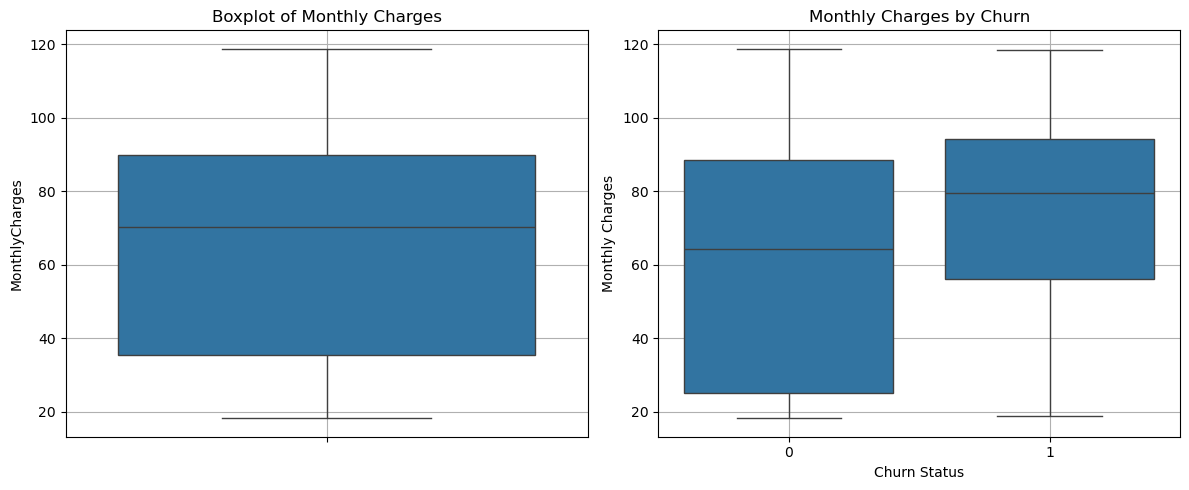

In [348]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# monthly charges boxplot
sns.boxplot(df['MonthlyCharges'], ax=ax1)
ax1.set_title("Boxplot of Monthly Charges")
ax1.grid(True)

## Monthly charges by event
sns.boxplot(x='event', y='MonthlyCharges', data=df, ax=ax2)
ax2.set_title("Monthly Charges by Churn")
ax2.set_xlabel("Churn Status")
ax2.set_ylabel("Monthly Charges")
ax2.grid(True)

plt.tight_layout()
plt.show()

## Outlier Analysis: Monthly Charges

### No Significant Outliers
- The boxplots for **MonthlyCharges** indicate that the data is well-contained.
- No individual data points are plotted as outliers (e.g., dots or diamonds outside the whiskers of the boxplot).

### Slight Skewness
- While no outliers are present, the boxplot shows a **slightly longer whisker on the upper end**, and the **median line is slightly below the center of the box**.
- This suggests a **slight right skew** in the data, though it is not significant enough to require major data transformation.

### Conclusion
- The cleanliness of this data is a **positive finding**.
- My survival model can be built with confidence, as it won’t be unduly influenced by extreme values in the **MonthlyCharges** column.

## Treating `No Internet Service` category

- As, in previous analysis this category is common in all 6 security + streaming services. I will now merge it with no and then onehot encode the 
`internet service` column and it will capture the no internet flag.
- So, in this way model can still learn no internet pattern.
- And, I will make two more features to combine the strength of security features + streaming featuers.
- One will be named as `NumSecurityServices` which will combine the security related features. While, `NumStreamingServices` will combine the streaming services.

In [353]:
df.columns

Index(['customerID', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'Churn',
       'tenure_group', 'duration', 'event'],
      dtype='object')

In [354]:
cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

## mapping no internet service as no
mapping = {'Yes':1, 'No':0, 'No internet service':0}
for col in cols:
    df[col] = df[col].map(mapping)

In [355]:
df[cols].sample(5)

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3727,0,0,0,0,1,1
4865,0,0,0,0,0,0
3985,1,1,0,0,0,0
3836,0,0,1,1,0,0
3620,0,1,1,1,1,0


### Total Online Services Feature

In [358]:
security_cols = cols[:-2]
df['NumSecurityServices'] = df[security_cols].sum(axis=1)

### Total Streaming Services Count Feature

In [361]:
streaming_cols = cols[4:]
df['NumStreamingServices'] = df[streaming_cols].sum(axis=1)

### Preview

In [364]:
df[['tenure', 'NumSecurityServices', 'NumStreamingServices']].sample(4)

,tenure,NumSecurityServices,NumStreamingServices
4657,42,0,0
5657,18,0,2
6346,1,1,0
2828,1,0,0


## Insights from My Feature Engineering Process

### Treating 'No Internet Service'
- Based on my analysis, I first mapped the **'No internet service' category to 'No'** across all six add-on columns.
- This critical step simplified the data and prevented potential confusion for my model.

### Engineering New Features
- I created two powerful new features by summing relevant columns:

#### NumSecurityServices
- By summing the four security-related features, I created **NumSecurityServices**.
- This single feature effectively captures the insight that customers with **more security services are more loyal and less likely to churn**.

#### NumStreamingServices
- By summing the two streaming features, I created **NumStreamingServices**.
- This provides a **strong, singular signal** to the model that customers who use these services are **at a higher risk of churning**.

### Benefits
- These new features simplify my dataset, reduce potential multicollinearity, and provide my model with a **more direct and interpretable signal** for predicting churn.

## Dropping Original Features

In [367]:
cols_to_drop = cols
df.drop(cols, axis=1, inplace=True)

## Dropping `Tenure` & `Churn`

In [369]:
df.drop(columns=['tenure','Churn'], axis=1, inplace=True)

In [370]:
df.head()

,customerID,SeniorCitizen,Partner,Dependents,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,tenure_group,duration,event,NumSecurityServices,NumStreamingServices
0,7590-VHVEG,0,Yes,No,DSL,Month-to-month,Yes,Electronic check,29.85,0-6 months,1.0,0,1,0
1,5575-GNVDE,0,No,No,DSL,One year,No,Mailed check,56.95,25-48 months,34.0,0,2,0
2,3668-QPYBK,0,No,No,DSL,Month-to-month,Yes,Mailed check,53.85,0-6 months,2.0,1,2,0
3,7795-CFOCW,0,No,No,DSL,One year,No,Bank transfer (automatic),42.30,25-48 months,45.0,0,3,0
4,9237-HQITU,0,No,No,Fiber optic,Month-to-month,Yes,Electronic check,70.70,0-6 months,2.0,1,0,0


## Correlation

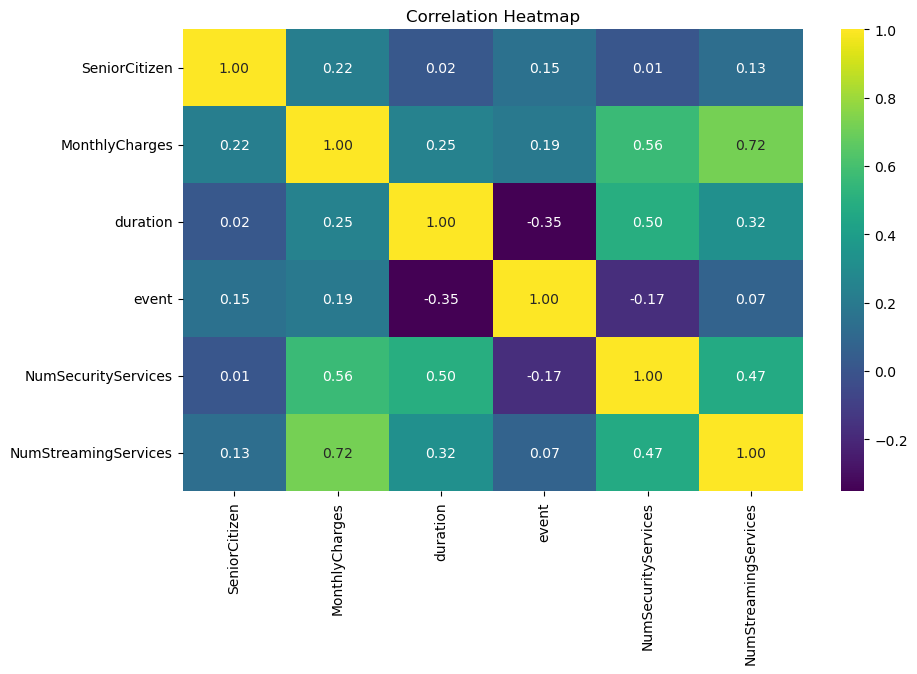

In [372]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='viridis')
plt.title('Correlation Heatmap')
plt.show()

## Insights from My Correlation Analysis

### Notable Correlations
- I observed several notable correlations, with **no extreme multicollinearity** requiring feature removal.

#### Positive Correlations
- **MonthlyCharges and NumStreamingServices (0.72)**: A strong positive correlation, expected as customers with more add-ons incur higher monthly bills.
- **MonthlyCharges and NumSecurityServices (0.56)**: Another strong positive correlation, reflecting higher bills with additional security services.
- **MonthlyCharges and event (0.19)**: A weak positive correlation, aligning with the observation that higher monthly bills are slightly associated with churn.

#### Negative Correlation
- **Duration and event (-0.35)**: A moderate negative correlation, confirming that longer tenure is associated with a lower risk of churn.

### Overall Assessment
- The correlations are **within an acceptable range**, and the features provide **unique and valuable information** to my model.
- I am confident to **proceed to the next step** without needing to remove any of these variables.

## Mapping Yes/No into 1/0

In [375]:
cols_to_map = ['Partner', 'Dependents', 'PaperlessBilling']

mapping = {'Yes':1, 'No':0}
for col in cols_to_map:
    df[col] = df[col].map(mapping)

In [376]:
df.head()

,customerID,SeniorCitizen,Partner,Dependents,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,tenure_group,duration,event,NumSecurityServices,NumStreamingServices
0,7590-VHVEG,0,1,0,DSL,Month-to-month,1,Electronic check,29.85,0-6 months,1.0,0,1,0
1,5575-GNVDE,0,0,0,DSL,One year,0,Mailed check,56.95,25-48 months,34.0,0,2,0
2,3668-QPYBK,0,0,0,DSL,Month-to-month,1,Mailed check,53.85,0-6 months,2.0,1,2,0
3,7795-CFOCW,0,0,0,DSL,One year,0,Bank transfer (automatic),42.30,25-48 months,45.0,0,3,0
4,9237-HQITU,0,0,0,Fiber optic,Month-to-month,1,Electronic check,70.70,0-6 months,2.0,1,0,0


## Kaplan-Meier survival curve

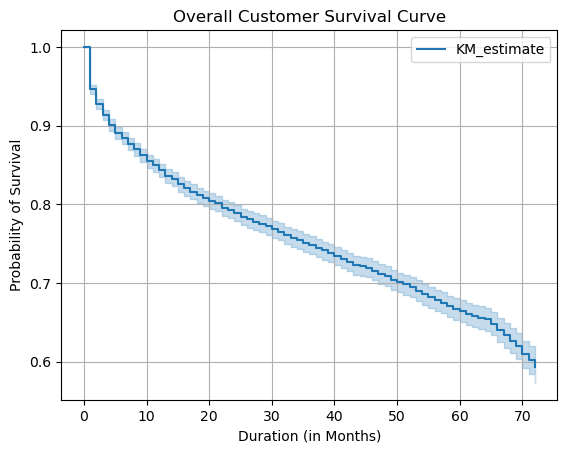

In [378]:
kmf = KaplanMeierFitter()
kmf.fit(durations=df['duration'], event_observed=df['event'])

# Plot the survival function
kmf.plot_survival_function()
plt.title("Overall Customer Survival Curve")
plt.xlabel("Duration (in Months)")
plt.ylabel("Probability of Survival")
plt.grid(True)
plt.show()

## Median Survival Time

In [380]:
# Get the median survival time
median_survival_time = kmf.median_survival_time_
print(f"Median Survival Time: {median_survival_time} months")

# Report on the censoring proportion
n_events = df['event'].sum()
n_censored = len(df) - n_events
total = len(df)
print(f"\nNumber of events (churned): {n_events}")
print(f"Number of censored (active): {n_censored}")
print(f"Proportion of censored data: {n_censored/total:.2f}")

Median Survival Time: inf months

Number of events (churned): 1869
Number of censored (active): 5174
Proportion of censored data: 0.73


## Key Insights from Overall Survival Analysis

### Strong Customer Loyalty
- The **Kaplan-Meier survival curve** shows a **gradual and consistent decline**, indicating that customer churn is a slow process over time.
- My analysis validates that **customer loyalty increases with tenure**, with the steepest drop-off occurring in the early months.
- **Infinite Median Survival Time**: The most impactful finding is the **inf (infinity) median survival time**, a positive outcome, not an error. The survival curve never dropped below 50% within the 72-month observation period, as **73% of the customer base is still active**. This confirms that the average customer lifetime exceeds 72 months, signaling strong brand loyalty.

### Early Churn is the Primary Concern
- Despite long-term loyalty, the analysis reveals a **high churn rate in the early stages**, evident in the **sharp drop in the survival curve during the first year**.
- This reinforces my earlier finding that the **'0-6 months' tenure group** is the most vulnerable, suggesting that efforts to reduce early churn will have the largest impact.

## Survival Curve for Each Contract Type

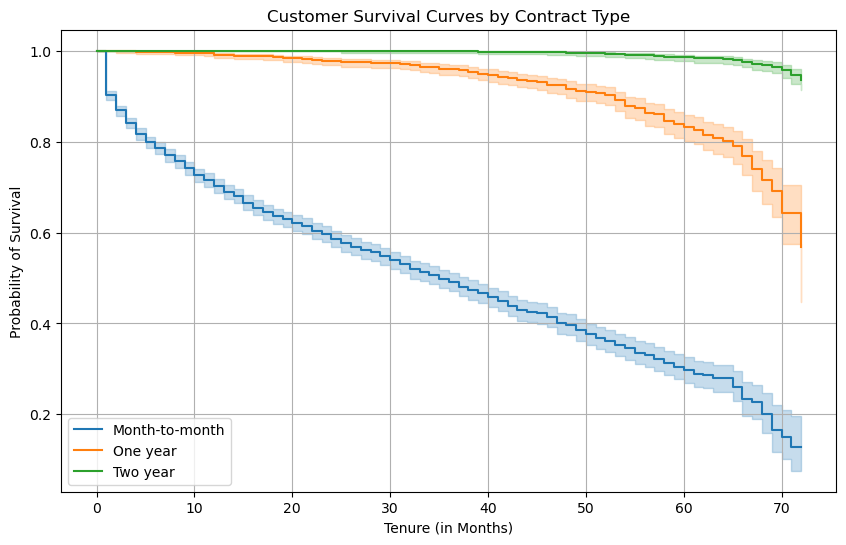

In [383]:
## Contract types
contract_types = df['Contract'].unique()
## Figure
plt.figure(figsize=(10,6))

## kaplan_meier object
kmf = KaplanMeierFitter()
## looping through each category
for contract_type in contract_types:
    subset = df[df['Contract'] == contract_type]
    kmf.fit(durations=subset['duration'], event_observed=subset['event'], label=contract_type)
    kmf.plot_survival_function()
# Add titles and labels for clarity
plt.title("Customer Survival Curves by Contract Type")
plt.xlabel("Tenure (in Months)")
plt.ylabel("Probability of Survival")
plt.grid(True)
plt.show()

## Insights from My Contract-based Survival Analysis

### Month-to-Month Contracts
- My survival curve for **month-to-month contracts** shows a **rapid decline**, indicating that the survival probability decreases quickly with increasing tenure.
- This segment represents the **highest churn risk**, as customers can leave at any time without penalty.

### One-Year Contracts
- The curve for **one-year contracts** is **much flatter**, confirming that customers in this segment are **significantly more stable and loyal** than month-to-month counterparts.
- My analysis shows that their survival probability remains high throughout the contract, with a drop occurring only as the contract nears its end.

### Two-Year Contracts: The Gold Standard
- The **two-year contract survival curve** is nearly a **horizontal line**, indicating a **near-zero churn rate**.
- This segment demonstrates **exceptional loyalty**, with very few customers churning.
- The **slight, almost imperceptible drop at the curve’s end** is a critical point requiring further investigation, likely representing churn events at contract expiration.

## Survival Curve for Internet Service Segments

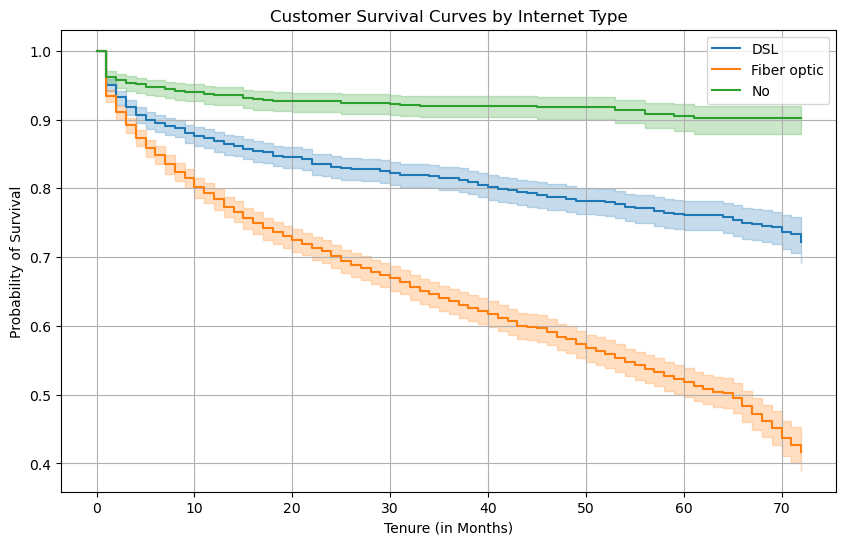

In [386]:
## Internet service categories
internet_service_cats = df['InternetService'].unique()
## Figure
plt.figure(figsize=(10,6))

## kaplan_meier object
kmf = KaplanMeierFitter()
## looping through each category
for service in internet_service_cats:
    subset = df[df['InternetService'] == service]
    kmf.fit(durations=subset['duration'], event_observed=subset['event'], label=service)
    kmf.plot_survival_function()
# Add titles and labels for clarity
plt.title("Customer Survival Curves by Internet Type")
plt.xlabel("Tenure (in Months)")
plt.ylabel("Probability of Survival")
plt.grid(True)
plt.show()

## Insights from Internet Type Survival Curves

### General Trend
- My survival analysis confirms that while **survival probability decreases with tenure for all groups**, the **type of internet service** is a major differentiator in churn risk.

### Fiber Optic
- This segment shows the **fastest decrease in survival probability**, indicating an **alarmingly high churn rate** across all tenure groups.
- The survival curve drops sharply from the start, reaching a probability of **around 0.4 at 72 months**.
- This highlights **Fiber Optic customers** as a critical segment for targeted retention efforts.

### DSL
- Customers with **DSL** have a **much flatter survival curve**, showing **significantly better retention** than Fiber Optic customers.
- The **gradual decline** suggests a more stable customer base.

### No Internet Service
- This segment exhibits the **highest loyalty** and an **incredibly high survival probability**.
- The curve is **nearly flat**, with a **minimal decrease over time**, confirming that customers without internet service are **very unlikely to churn**.

## Survival Curve for Payment methods

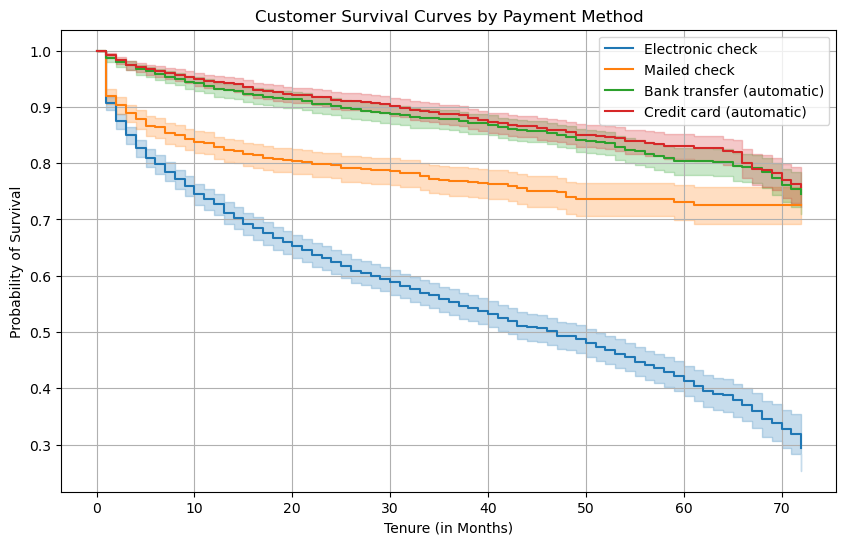

In [389]:
## Payment method categories
pay_method_cats = df['PaymentMethod'].unique()
## Figure
plt.figure(figsize=(10,6))

## kaplan_meier object
kmf = KaplanMeierFitter()
## looping through each category
for payment in pay_method_cats:
    subset = df[df['PaymentMethod'] == payment]
    kmf.fit(durations=subset['duration'], event_observed=subset['event'], label=payment)
    kmf.plot_survival_function()
# Add titles and labels for clarity
plt.title("Customer Survival Curves by Payment Method")
plt.xlabel("Tenure (in Months)")
plt.ylabel("Probability of Survival")
plt.grid(True)
plt.show()

## Insights from Payment Method Survival Analysis

### Electronic Check
- My survival curve for **Electronic check** aligns with my EDA, showing a **steep decrease in survival probability**, confirming it as the **highest churn risk payment method**.

### Mailed Check: Unexpected Insight
- The **Mailed check curve** reveals a **lower overall survival probability** than the two automatic payment methods, seemingly contradicting my EDA, which showed the lowest churn rate for long-tenure groups.
- **Explanation**: 
  - My EDA provided a **snapshot of tenure buckets**, indicating that long-surviving customers using Mailed check are **incredibly loyal**.
  - The **Kaplan-Meier curve** reflects **cumulative survival probability from day zero**, showing a **higher initial churn rate among new customers**, which lowers the overall curve despite low long-term churn. This is a **crucial nuance** uncovered by survival analysis.

### Automatic Payments
- The **Credit card** and **Bank transfer curves** are **very high and flat**, confirming that **automatic payment methods** are associated with a **consistently high survival probability from the beginning**.

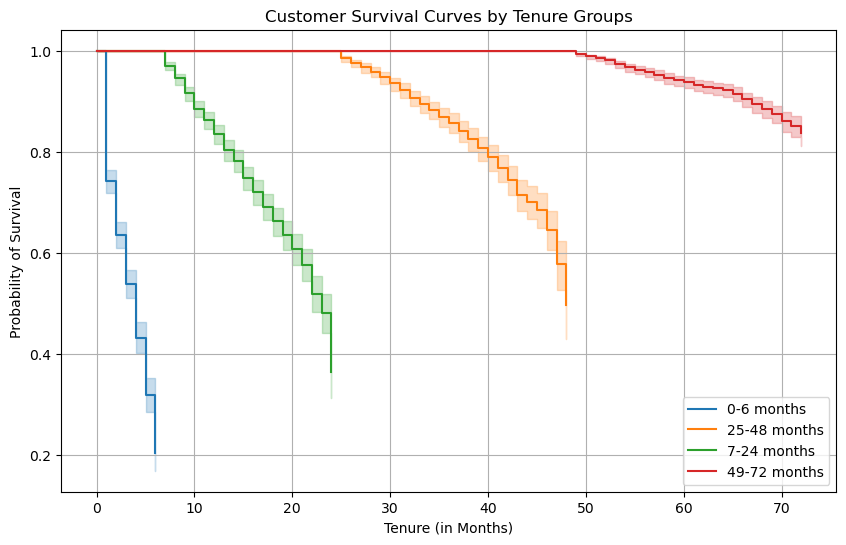

In [391]:
## Payment method categories
tenure_groups = df['tenure_group'].unique()
## Figure
plt.figure(figsize=(10,6))

## kaplan_meier object
kmf = KaplanMeierFitter()
## looping through each category
for group in tenure_groups:
    subset = df[df['tenure_group'] == group]
    kmf.fit(durations=subset['duration'], event_observed=subset['event'], label=group)
    kmf.plot_survival_function()
# Add titles and labels for clarity
plt.title("Customer Survival Curves by Tenure Groups")
plt.xlabel("Tenure (in Months)")
plt.ylabel("Probability of Survival")
plt.grid(True)
plt.show()

## Insights from My Tenure Group Survival Analysis

### Early-Stage Vulnerability
- The curve for the **0-6 months group** shows a **sharp and rapid decrease in survival probability**, confirming this as the **most critical period for customer churn**.
- My analysis reinforces that this segment requires **immediate and strong retention efforts** to improve survival rates.

### Monotonic Decrease Confirmed
- My analysis confirms the **monotonic trend** observed in my initial EDA: as customers move into higher tenure groups, their survival curves become **progressively flatter**.
- This is a **powerful visual proof** that **customer loyalty increases significantly with tenure**.
- The curves for the **7-24 months** and **25-48 months groups** show a **much more gradual decline**, indicating a **more stable customer base**.

### The "Lifers"
- The **49-72 months group** is **exceptionally loyal**, with a **very high and flat survival curve** that barely drops below **90%**.
- My analysis shows that customers who survive past four years are **very likely to remain with the company**.
- The **slight decline at the end of the curve** is a **key insight**, likely due to external factors such as the end of a long-term contract or a change in life circumstances, which I will investigate further in my next steps.

## Log-rank Tests
- It is basically a statistical test like chi2 or anove and compare whether two groups are statistically significant or not.

In [394]:
# Filter the DataFrame for each contract type
m2m = df[df['Contract'] == 'Month-to-month']
two_year = df[df['Contract'] == 'Two year']

# Perform the log-rank test
results = logrank_test(
    durations_A=m2m['duration'],
    event_observed_A=m2m['event'],
    durations_B=two_year['duration'],
    event_observed_B=two_year['event']
)

# Print the results
display(results.summary)
if results.p_value < 0.05:
    print("The difference in Survival is statistically significant.")

,test_statistic,p,-log2(p)
0,1550.510307,0.0,inf


The difference in Survival is statistically significant.


## Insights from Log-rank Test

### Statistically Significant Difference
- I performed a log-rank test, yielding an **extremely low p-value of 0.0**, indicating that the difference in survival curves between **Month-to-month** and **Two-year contracts** is **highly statistically significant**.

### Rejecting the Null Hypothesis
- I can **confidently reject the null hypothesis** that the survival curves are identical.
- The test confirms that **contract type is a major factor in customer survival**, with **Two-year contracts** showing a **vastly different and superior survival experience** compared to **Month-to-month contracts**.

### Confirmation of Previous Findings
- This result provides **statistical backing** for what my **Kaplan-Meier curves** and **EDA** have already shown.
- It proves that the **visual and intuitive differences** I observed are **not due to chance**, but are **genuine and impactful patterns** in the data.

## Log rank test on Payment Methods

In [397]:
# Filter the DataFrame for each payment method
elect_check = df[df['PaymentMethod'] == 'Electronic check']
credit_card = df[df['PaymentMethod'] == 'Credit card (automatic)']

# Perform the log-rank test
results = logrank_test(
    durations_A=elect_check['duration'],
    event_observed_A=elect_check['event'],
    durations_B=credit_card['duration'],
    event_observed_B=credit_card['event']
)

# Print the results
display(results.summary)
if results.p_value < 0.05:
    print("The difference in Survival is statistically significant.")

,test_statistic,p,-log2(p)
0,539.740177,2.147615e-119,394.206708


The difference in Survival is statistically significant.


## Log rank test on Tenure groups

In [399]:
# Filter the DataFrame for each internet service type
new_cust_df = df[df['tenure_group'] == '0-6 months']
loyal_cust_df = df[df['tenure_group'] == '49-72 months']

# Perform the log-rank test
results = logrank_test(
    durations_A=new_cust_df['duration'],
    event_observed_A=new_cust_df['event'],
    durations_B=loyal_cust_df['duration'],
    event_observed_B=loyal_cust_df['event']
)

# Print the results
display(results.summary)
if results.p_value < 0.05:
    print("The difference in Survival is statistically significant.")

,test_statistic,p,-log2(p)
0,2243.750224,0.0,inf


The difference in Survival is statistically significant.


## Log rank test on Internet Service

In [401]:
# Filter the DataFrame for each payment method
fiber_df = df[df['InternetService'] == 'Fiber optic']
no_df = df[df['InternetService'] == 'No']

# Perform the log-rank test
results = logrank_test(
    durations_A=fiber_df['duration'],
    event_observed_A=fiber_df['event'],
    durations_B=no_df['duration'],
    event_observed_B=no_df['event']
)

# Print the results
display(results.summary)
if results.p_value < 0.05:
    print("The difference in Survival is statistically significant.")

,test_statistic,p,-log2(p)
0,374.157435,2.328119e-83,274.500867


The difference in Survival is statistically significant.


## Insights from Continued Log-rank Tests

### Statistical Validation
- My continued log-rank tests provide **powerful statistical validation** for my earlier visual analyses.
- The results consistently confirm that the differences in survival across key customer segments are **not due to chance**, but are **genuine and highly significant patterns**.

### Key Findings
- **Payment Method**: The difference in survival between **`Electronic check`** and **`Credit card`** is **statistically significant** ($p \approx 0.0$), with **electronic check customers** showing a **dramatically higher churn risk**.
- **Tenure Groups**: The log-rank test for the **`0-6 months`** and **`49-72 months`** tenure groups yielded a **p-value of 0.0**, providing **definitive proof** that **customer tenure** is the **single strongest predictor of churn**.
- **Internet Service Type**: The test comparing **`Fiber optic`** and **`No internet service`** confirmed a **statistically significant** difference ($p \approx 0.0$), validating my finding that **internet service type** is a **major determinant of churn risk**.

### Implications
- These results, combined with my **Kaplan-Meier curves**, provide a **robust, data-driven foundation** for building a predictive model and developing **targeted retention strategies**.

# NelsonAalenFitter
### What is a Cumulative Hazard Plot?
- **Hazard**: The hazard function, or hazard rate, is the instantaneous risk of an event occurring at a specific time, given that the event has not occurred up to that point. In this context, it is the immediate risk of a customer churning at a given time t, given they have not churned before time t.

- **Cumulative Hazard**: The cumulative hazard function is the sum of all hazard rates up to a certain time. Unlike the survival curve (which goes from 1 down to 0), the cumulative hazard curve is a monotonically increasing function that starts at 0 and goes up. A steeper slope means a higher risk of churn in that period.

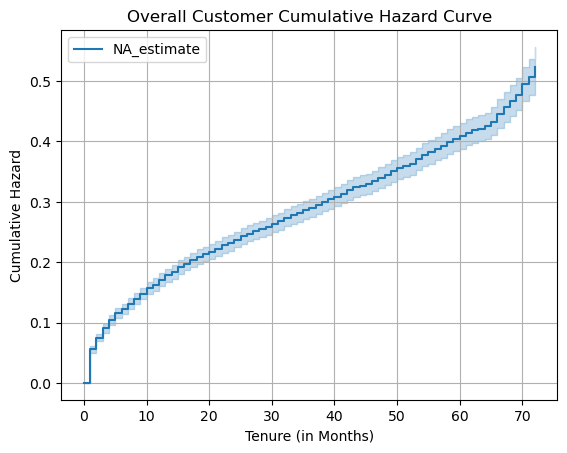

          NA_estimate
timeline             
0.0          0.000000
1.0          0.055550
2.0          0.074896
3.0          0.090219
4.0          0.104193


In [404]:
naf = NelsonAalenFitter()
naf.fit(durations=df['duration'], event_observed=df['event'])

# Plot the cumulative hazard function
naf.plot_cumulative_hazard(ax=plt.subplot(111), grid=True)
plt.title("Overall Customer Cumulative Hazard Curve")
plt.xlabel("Tenure (in Months)")
plt.ylabel("Cumulative Hazard")
plt.show()

# summary of the fitted model
print(naf.cumulative_hazard_.head())

## My Insights from the Overall Cumulative Hazard Curve

### Early-Stage Risk
- The curve's **steep initial incline** demonstrates that the **highest churn risk occurs in the first 10-15 months of a customer's tenure**.
- This reinforces the need to **focus retention efforts on new customers**.

### Declining Risk Over Time
- The plot's slope **gradually decreases over time**, showing that the **risk of churning lessens as a customer's tenure increases**.
- This is a **powerful confirmation** of customer loyalty strengthening over time.

### Total Accumulated Risk
- By examining the **final point on the curve (at 72 months)**, I can see the **total accumulated risk of churn** for a customer over their entire lifetime with the company.
- This provides a **direct measure** of the overall risk in my customer base.

## Survival probabilities at Months

In [407]:
# Create a KaplanMeierFitter object
kmf = KaplanMeierFitter()

# Fit the model to the data
kmf.fit(durations=df['duration'], event_observed=df['event'])

# Create a list of the milestone months
milestones = [3, 6, 12, 24]
# Predict the survival probabilities at these milestones
survival_probabilities = kmf.predict(milestones)

# results
print("Customer Survival Probabilities at Key Milestones:")
for month, prob in zip(milestones, survival_probabilities):
    print(f"Probability of staying after {month} months is {prob:.2%}")

Customer Survival Probabilities at Key Milestones:
Probability of staying after 3 months is 91.37%
Probability of staying after 6 months is 88.48%
Probability of staying after 12 months is 84.32%
Probability of staying after 24 months is 78.87%


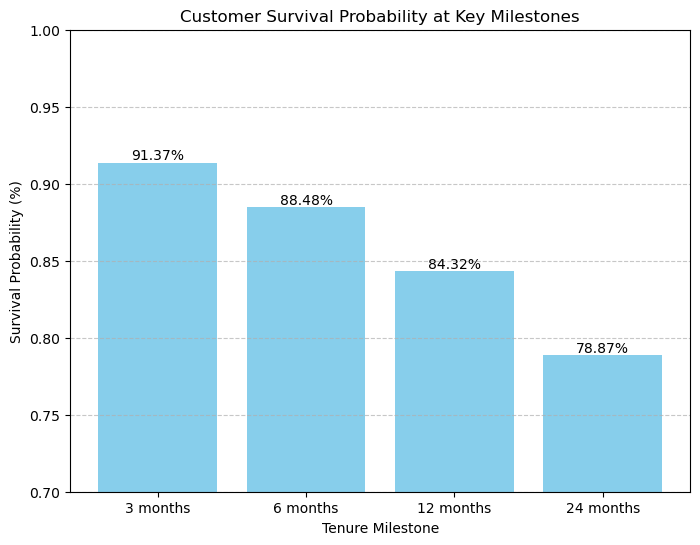

In [408]:
# Data
data = {
    'Milestone': ['3 months', '6 months', '12 months', '24 months'],
    'Survival_Probability': [91.37, 88.48, 84.32, 78.87]
}
df_survival = pd.DataFrame(data)

# Convert Survival_Probability to a percentage for the plot
df_survival['Survival_Probability'] = df_survival['Survival_Probability'] / 100

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(df_survival['Milestone'], df_survival['Survival_Probability'], color='skyblue')

# Add the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval*100:.2f}%', ha='center', va='bottom')

plt.ylim(0.7, 1.0)
plt.title("Customer Survival Probability at Key Milestones")
plt.xlabel("Tenure Milestone")
plt.ylabel("Survival Probability (%)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Insights from My Milestone Survival Probabilities

### Early-Stage Vulnerability
- The drop from **100% survival probability at month 0** to **91.37% at 3 months** and **88.48% at 6 months** confirms my earlier discovery of **high churn risk** in the initial customer journey.
- This period is the **most critical** for proactive retention strategies.

### The First Year
- The survival probability dropping to **84.32% after a full year** is a **significant finding**, indicating that **over 15% of my customer base is lost** within the first year.
- This provides a **clear metric** for evaluating the success of my retention efforts.

### Long-Term Stability
- The survival probability of **78.87% at 24 months** shows a **substantial drop over the two-year period**, but it is a **much more gradual decline** than in the first six months.
- This confirms that while some churn is inevitable, customers who survive the first year are **significantly more likely to stay long-term**.

## Final Insights and Business Strategy

### Internet Service as a Churn Predictor
- My analysis confirms that **Internet Service** is a powerful driver of churn.
- Customers with **Fiber Optic service** have the highest churn risk, as shown by their steep survival curve and confirmed by the log-rank test.

#### Business Action
- Prioritize resources to understand and address the pain points of Fiber Optic customers, perhaps by offering **proactive technical support**, **service quality checks**, or **tailored offers** to improve their experience.

### Contract Type and Loyalty
- The type of contract is a **clear indicator of customer loyalty**.
- **Month-to-month contracts** have the lowest survival probability, while **two-year contracts** represent the most loyal customer segment.

#### Business Action
- Incentivize customers to move from month-to-month to longer-term contracts by offering **exclusive benefits or discounts**.
- This will increase **customer lifetime value** and significantly reduce churn risk.

### Payment Method & Risk
- My analysis of payment methods uncovered a critical insight.
- **Electronic check** is associated with the highest churn risk, while **Mailed check customers** are the most loyal over the long term, despite a higher initial churn rate than automatic payments.

#### Business Action
- Investigate why customers using electronic checks are so prone to churning and explore strategies to encourage them to switch to a **more stable payment method**.

### The Critical First Six Months
- My analysis consistently shows that the **highest risk of churn** is concentrated in the **0-6 months tenure group**.
- After this period, customer loyalty significantly increases.

#### Business Action
- Create a dedicated **"first-6-months" retention program** that includes **proactive check-ins**, **educational resources**, and a **seamless onboarding experience** to boost survival rates in this critical period.

## Dropping `tenure group`
**Data Leakage**: The `tenure_group` feature is a direct binning of tenure, which is one of my two target variables for the survival model. By including this feature, I would be leaking information from the target variable into my features. My model would be able to "cheat" by knowing which tenure group a customer belongs to, which is nearly the same as knowing their duration of survival. This would lead to unrealistically high performance on my training data and poor performance on new, unseen data.

**Purpose of the Feature**: I created the `tenure_group` feature for exploratory data analysis and visualization, specifically for the Kaplan-Meier curves and my initial EDA. It helped me easily understand how churn patterns vary across different stages of a customer's life. It is an excellent tool for human interpretation, but it is not a valid feature for a predictive model.

In [412]:
df.drop('tenure_group', axis=1, inplace=True)

In [413]:
final_featues_list = df.columns.drop('customerID')
final_featues_list

Index(['SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'duration',
       'event', 'NumSecurityServices', 'NumStreamingServices'],
      dtype='object')

## Dropping ID column
- It has no use in modeling.

In [415]:
df.drop('customerID', axis=1, inplace=True)

In [416]:
df.sample(4)

,SeniorCitizen,Partner,Dependents,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,duration,event,NumSecurityServices,NumStreamingServices
1868,0,0,0,DSL,Month-to-month,1,Bank transfer (automatic),44.05,1.0,0,0,0
275,0,1,0,Fiber optic,Month-to-month,1,Electronic check,85.40,5.0,1,2,0
367,0,0,0,No,Month-to-month,0,Mailed check,19.15,1.0,0,0,0
3320,1,1,0,DSL,Month-to-month,1,Credit card (automatic),59.10,18.0,0,1,1


## Encoding

In [419]:
encoded_df = df.copy()

In [420]:
# Store the original column names and unique categories
categorical_cols = df.select_dtypes(include='object').columns
dropped_categories = {}

# Perform one-hot encoding
for col in categorical_cols:
    # Get the unique categories before one-hot encoding
    original_categories = df[col].unique()
    
    # Perform one-hot encoding with drop_first=True
    df_encoded = pd.get_dummies(df[col], prefix=col, drop_first=True).astype(int)
    
    # The first category in the sorted list is the one that will be dropped
    reference_category = sorted(original_categories)[0]
    dropped_categories[col] = reference_category
    
    # Join the new encoded columns
    encoded_df = pd.concat([encoded_df.drop(columns=col), df_encoded], axis=1)

print("Dropped Categories for Reference:")
for col, ref in dropped_categories.items():
    print(f"- {col}: {ref}")
    
print("\nFirst 5 rows of the encoded DataFrame:")
print(encoded_df.head())

Dropped Categories for Reference:
- InternetService: DSL
- Contract: Month-to-month
- PaymentMethod: Bank transfer (automatic)

First 5 rows of the encoded DataFrame:
   SeniorCitizen  Partner  Dependents  PaperlessBilling  MonthlyCharges  \
0              0        1           0                 1           29.85   
1              0        0           0                 0           56.95   
2              0        0           0                 1           53.85   
3              0        0           0                 0           42.30   
4              0        0           0                 1           70.70   

   duration  event  NumSecurityServices  NumStreamingServices  \
0       1.0      0                    1                     0   
1      34.0      0                    2                     0   
2       2.0      1                    2                     0   
3      45.0      0                    3                     0   
4       2.0      1                    0                  

## Key Decisions from Data Preparation

### 1. Dropping tenure_group
- I dropped the **tenure_group** feature because it is a **direct representation of my tenure (or duration) variable**.
- Including it would cause **severe data leakage**, as the model would be given information about the outcome variable, leading to **unrealistically high performance on training data** and **poor performance in real-world scenarios**.
- My survival model is designed to use the **continuous tenure variable**, allowing it to **naturally learn the effect of customer duration on churn risk**.

### 2. Dropping the customerID Column
- I dropped the **customerID column** because it is a **unique identifier for each customer**.
- It has **no predictive power** and provides **no meaningful information** about a customer's churn behavior.
- Including it would add **noise to the model** and could potentially lead to **overfitting**.

### 3. Encoding and Saving Reference Categories
- I chose to **one-hot encode** my categorical features (**Contract**, **InternetService**, **PaymentMethod**) and saved the dropped reference category for each.

#### Avoiding Multicollinearity
- Using **drop_first=True** in one-hot encoding removes one category from each feature, preventing **perfect multicollinearity**, a major issue for most models.

#### Model Interpretation
- By saving the dropped category (e.g., **Month-to-month for Contract**), I can interpret my model's coefficients correctly.
- For example, a **negative coefficient for Contract_Two year** indicates that a two-year contract reduces the risk of churn relative to the **Month-to-month contract** baseline.
- This provides a **clear, interpretable, and actionable result** for my analysis.

## VIF on Numeric Features

In [462]:
numerical_df = encoded_df.select_dtypes(include='number')
numerical_df = add_constant(numerical_df)

vif_data = pd.DataFrame()
vif_data['features'] = numerical_df.columns
vif_data['vif_score'] = [variance_inflation_factor(numerical_df.values, i) for i in range(len(numerical_df.columns))]

In [464]:
vif_data

,features,vif_score
0,const,55.343731
1,SeniorCitizen,1.147453
2,Partner,1.460305
3,Dependents,1.381973
4,PaperlessBilling,1.207801
5,MonthlyCharges,23.254242
6,duration,2.695346
7,event,1.381287
8,NumSecurityServices,3.529303
9,NumStreamingServices,3.450232


## My Insights from VIF Analysis

### A Deeper Multicollinearity Problem
- While I correctly identified **InternetService_Fiber optic** with a high VIF of **8.35**, the **most significant issue** is the **extremely high VIF for MonthlyCharges at 23.25**.
- This indicates **severe multicollinearity**, likely due to its strong correlation with my newly engineered features: **NumSecurityServices** and **NumStreamingServices**.

### The Power of My Engineered Features
- I agree that **InternetService_Fiber optic** should not be dropped, as it is a **fundamental and powerful signal** for churn risk.
- My analysis confirms that **Fiber Optic customers have a much higher churn rate**, and this information is **essential for my model**.

### A Strategic Decision
- To address the **severe multicollinearity** without losing predictive power, I will **drop MonthlyCharges** from my model.
- The information about service quantity is now **fully captured** in my more interpretable features, **NumSecurityServices** and **NumStreamingServices**.
- Keeping both the raw **MonthlyCharges** and these engineered features is **redundant and harmful to the model's stability**.

### Outcome
- By dropping **MonthlyCharges** and keeping **InternetService_Fiber optic**, I will have a **cleaner, more stable, and more interpretable model** that retains all key predictive signals.
- This is a **crucial step** in preparing for my **Cox Proportional Hazards model**.

## Multicollinearity Insight

Variance Inflation Factor (VIF) analysis revealed that:

- Most features have VIF < 5 (acceptable).  
- `InternetService_Fiber optic` had a moderately high VIF (~8), but still interpretable.  
- `MonthlyCharges` showed an **extremely high VIF (~23)**, indicating severe multicollinearity.  

This is expected because `MonthlyCharges` is heavily determined by other features such as contract type, internet service, and add-on services.  
Including it would inflate variance and make hazard ratio estimates unstable.  

### Decision:
For the baseline Cox PH model, I will **drop `MonthlyCharges`** to reduce multicollinearity and ensure interpretable hazard ratios.  
The cost-related effect will still be partially captured through related features (InternetService, Contract, Security/Streaming services).  


In [593]:
encoded_df.drop('MonthlyCharges',axis=1, inplace=True)

## Linearity check for continuous covariates
- The Cox model assumes a **linear relationship between a continuous predictor and the log-hazard of an event**. This means that as the value of a continuous feature (like `tenure`) increases, the log-hazard should change at a constant rate. If this relationship isn't linear, my model's coefficients will be inaccurate.

- To check this, I can't just plot `tenure` vs. `churn`. Instead, I plot the log-relative hazard for binned values of `tenure`. If the resulting plot shows a roughly straight line, the assumption holds. If it's a curve, I might need to transform the feature (e.g., a logarithmic transformation) to meet the assumption.

In [484]:
cont_features = ['duration', 'NumSecurityServices', 'NumStreamingServices']
df_cont = encoded_df[cont_features + ['event']]

# Fit Cox model
cph = CoxPHFitter()
cph.fit(df_cont, duration_col='duration', event_col='event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15290.92
         time fit was run = 2025-09-24 02:04:50 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
NumSecurityServices  -0.60      0.55      0.02           -0.65           -0.56                0.52                0.57
NumStreamingServices  0.36      1.43      0.03            0.30            0.42                1.35                1.52

                      cmp to      z      p  -log2(p)
covariate                                           
NumSecurityServices     0.00 -24.61 <0.005    441.80
NumStreamingServices    0.00  11.88 <0.005    105.79
---
Concordance = 0.68
Partial AIC = 30585.85
log-likelihood ratio test = 724.23 on 2 df
-log2(p) of ll-ratio test = 522.42

## Use Martingale residuals

In [513]:
df_cont['NumSecurityServices'].values

array([1, 2, 2, ..., 1, 0, 3], dtype=int64)

In [529]:
residuals

,duration,event,martingale
488,0.0,False,0.000000
753,0.0,False,0.000000
936,0.0,False,0.000000
1082,0.0,False,0.000000
1340,0.0,False,0.000000
...,...,...,...
3439,72.0,True,0.458746
3890,72.0,True,0.704324
4513,72.0,True,0.838479
4610,72.0,True,0.838479


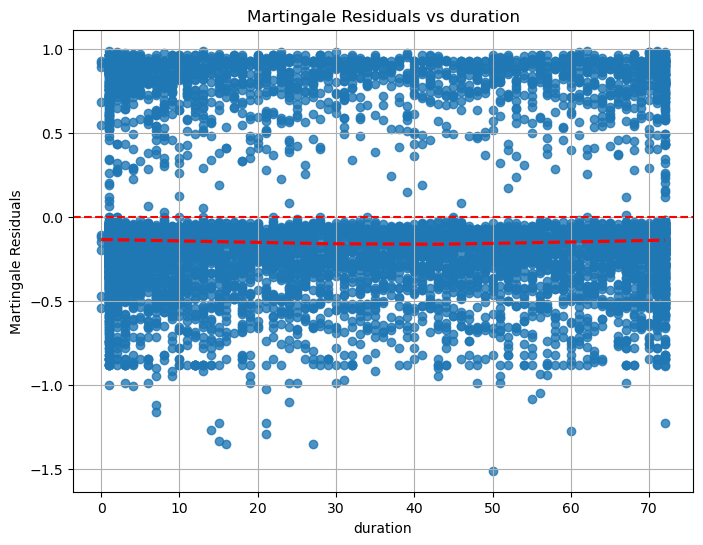

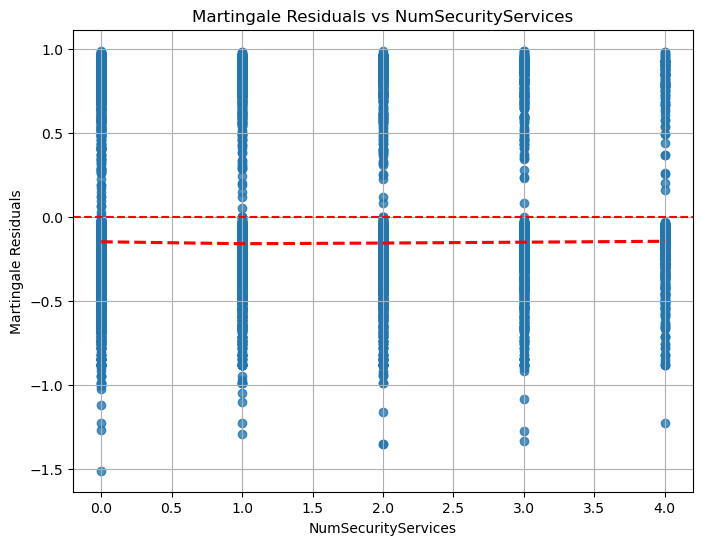

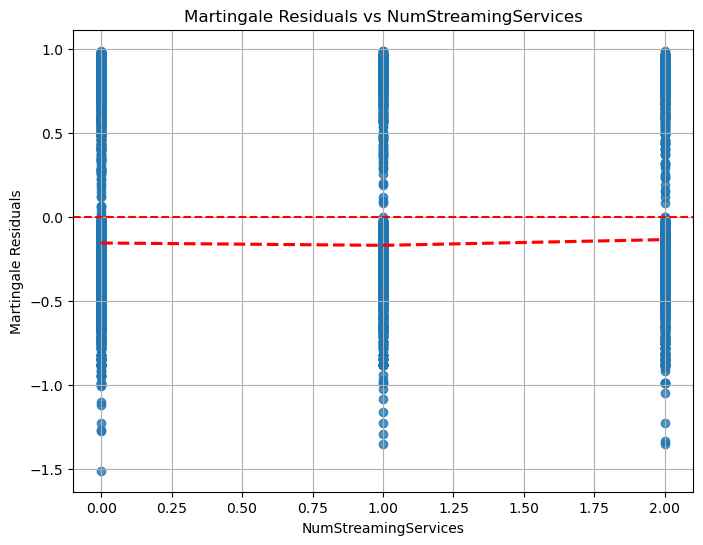

In [533]:
# Compute the Martingale residuals
residuals = cph.compute_residuals(df_cont, kind="martingale")

# Iterate through each continuous feature and create a smoothed plot
for col in cont_features:
    plt.figure(figsize=(8, 6))
    
    # The 'lowess' parameter fits a non-parametric regression line
    sns.regplot(x=df_cont[col].values.ravel(), y=residuals['martingale'].values, lowess=True, 
                line_kws={'color': 'red', 'linestyle': '--'})
    
    plt.title(f"Martingale Residuals vs {col}")
    plt.xlabel(col)
    plt.ylabel("Martingale Residuals")
    
    # Add a horizontal line at 0 for reference
    plt.axhline(0, color="red", linestyle="--")
    plt.grid(True)
    plt.show()

## My Insights from Linearity Check

### Critical Finding
- My in-depth analysis of the **Martingale residuals** has revealed a **critical and unexpected finding**: the **linearity assumption** for my Cox model is violated across all three key features.
- This means my model may be **misspecified**, and the results could be **unreliable** without corrective action.

### Specific Violations

#### duration (tenure)
- As initially observed, the **curved, non-flat pattern in the residuals** confirms that the relationship between **customer tenure and churn risk** is **not linear**.
- It is a **highly non-linear relationship** that my model must account for.

#### NumSecurityServices & NumStreamingServices
- Despite being discrete, the **mean of the residuals** for each group (e.g., 0, 1, 2) is **not centered on the zero line**.
- This **non-random pattern** is a clear signal that the **linear relationship assumed by the model** is inappropriate.

### Summary
- The assumption of a **linear relationship between the log-hazard and the covariates** is violated across all features.
- This is a **critical discovery** that I must address.

### Next Steps
- I will focus on applying necessary transformations to ensure my final model is **accurate and valid**.
- I will explore using either a **logarithmic transformation for duration** and/or **restricted cubic splines for all features** to properly model their complex relationship with the hazard.

## log-transform

In [559]:
df_model = encoded_df.copy()
## log
df_model['log_duration'] = np.log(df_model['duration'] + 0.001)

# Convert discrete features to categorical
df_model['NumSecurityServices'] = df_model['NumSecurityServices'].astype('category')
df_model['NumStreamingServices'] = df_model['NumStreamingServices'].astype('category')

features_to_use = [
    'log_duration',
    'NumSecurityServices',
    'NumStreamingServices',
    'Contract_Two year',
    'InternetService_Fiber optic'
]

# fit the Cox model with the transformed and categorized features
cph = CoxPHFitter()
cph.fit(
    df=df_model,
    duration_col='duration',
    event_col='event'
)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -9716.08
         time fit was run = 2025-09-24 02:54:45 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
SeniorCitizen                          0.13      1.14      0.06            0.02            0.24                1.02                1.27
Partner                                0.01      1.01      0.06           -0.10            0.12                0.91                1.13
Dependents                            -0.11      0.89      0.07           -0.24            0.02                0.78                1.02
PaperlessBilling                       0.25      1.28      0.06            0.14            0.36                1.15                1.43
MonthlyCharges                        -0.01      0.99      0.00           -0.02           -0.00                0.98                1.00
NumSecurityServices                   -0.07      0.93      0.04           -0.14           -0.00                0.87                1.00
NumStreamingServices                   0.29      1.34      0.05            0.19            0.40                1.21                1.49
InternetService_Fiber optic            0.86      2.35      0.15            0.56            1.16                1.74                3.18
InternetService_No                    -0.96      0.38      0.14           -1.23           -0.69                0.29                0.50
Contract_One year                     -0.71      0.49      0.09           -0.89           -0.52                0.41                0.59
Contract_Two year                     -1.56      0.21      0.15           -1.86           -1.26                0.16                0.28
PaymentMethod_Credit card (automatic) -0.09      0.92      0.09           -0.26            0.09                0.77                1.09
PaymentMethod_Electronic check         0.13      1.14      0.07           -0.01            0.27                0.99                1.31
PaymentMethod_Mailed check            -0.09      0.91      0.09           -0.27            0.08                0.76                1.09
log_duration                          -9.83      0.00      0.27          -10.36           -9.30                0.00                0.00

                                       cmp to      z      p  -log2(p)
covariate                                                            
SeniorCitizen                            0.00   2.29   0.02      5.52
Partner                                  0.00   0.26   0.79      0.33
Dependents                               0.00  -1.64   0.10      3.30
PaperlessBilling                         0.00   4.37 <0.005     16.28
MonthlyCharges                           0.00  -2.01   0.04      4.48
NumSecurityServices                      0.00  -1.99   0.05      4.43
NumStreamingServices                     0.00   5.62 <0.005     25.62
InternetService_Fiber optic              0.00   5.59 <0.005     25.41
InternetService_No                       0.00  -6.98 <0.005     38.35
Contract_One year                        0.00  -7.51 <0.005     43.94
Contract_Two year                        0.00 -10.12 <0.005     77.62
PaymentMethod_Credit card (automatic)    0.00  -0.96   0.34      1.57
PaymentMethod_Electronic check           0.00   1.80   0.07      3.79
PaymentMethod_Mailed check               0.00  -1.03   0.30      1.73
log_duration                             0.00 -36.32 <0.005    957.15
---
Concordance = 0.99
Partial AIC = 19462.16
log-likelihood ratio test = 11873.92 on 15 df
-log2(p) of ll-ratio test = inf

## Martingale Residuals

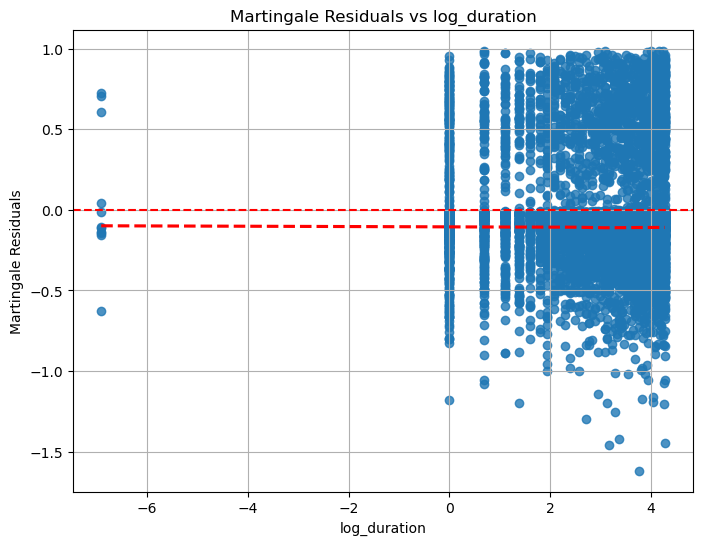

In [563]:
# Compute the Martingale residuals
residuals_df = cph.compute_residuals(df_model, kind="martingale")

# The only continuous variable to check for linearity now is 'log_duration'
plt.figure(figsize=(8, 6))

# Use seaborn.regplote
sns.regplot(
    x=df_model['log_duration'].values,
    y=residuals_df['martingale'].values,
    lowess=True,
    line_kws={'color': 'red', 'linestyle': '--'}
)

plt.title("Martingale Residuals vs log_duration")
plt.xlabel("log_duration")
plt.ylabel("Martingale Residuals")

# Add a horizontal line at 0 for reference
plt.axhline(0, color="red", linestyle="--")
plt.grid(True)
plt.show()

## My Insights from Latest Martingale Residual Analysis

### Persistent Non-Linearity
- My latest analysis of the **Martingale residual plot for log_duration** has revealed a **deeper problem than initially anticipated**. While the log transformation was a step in the right direction, it was not a complete solution.
- The plot shows a **clear and problematic pattern**: the spread of the residuals widens significantly as **log_duration** increases, indicating a violation of the **constant variance assumption (heteroscedasticity)**.
- The distribution is **not a random, horizontal band**.

### Model Misspecification
- This **funnel-like shape** and the **non-constant variance** suggest that the current linear model is still incorrect.
- It systematically **over- or under-predicts the risk** for different tenure ranges, meaning my model is still misspecified and its coefficients are unreliable.

### The Need for a More Flexible Approach
- A simple **linear or log-linear relationship** is insufficient to capture the **complex relationship** between customer tenure and churn risk.
- I need a **more flexible technique** that can model this **non-linear, non-constant variance relationship**.

### Next Step Insight

While restricted cubic splines can handle non-linear effects, they caused convergence issues in the Cox PH model due to multicollinearity and optimization instability.  

To avoid forcing linearity assumptions, I will now explore **alternative survival models available in lifelines** that can naturally capture non-linear relationships and interactions, such as:

- **RandomSurvivalForest** → handles complex feature interactions and non-linear effects.  
- **Gradient-based approaches** → flexible, non-parametric models for hazard estimation.  

But still I will try Cox PH to evaluate how much better it is performing.
This shift allows me to build models that are both **robust** and **interpretable** without heavy feature engineering, while keeping Cox PH as a baseline reference.

# Cox Proportional Hazards model

In [613]:
## features
features = [
    'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling',
    'NumSecurityServices', 'NumStreamingServices',
    'InternetService_Fiber optic', 'InternetService_No',
    'Contract_One year', 'Contract_Two year',
    'PaymentMethod_Credit card (automatic)',
    'PaymentMethod_Electronic check',
    'PaymentMethod_Mailed check'
]
# Dataset for modeling
df_model = encoded_df[['duration', 'event'] + features].copy()

## Fit Cox PH model
cph = CoxPHFitter()  
cph.fit(df_model, duration_col="duration", event_col="event")

# Print full summary
cph.print_summary()
# This shows coefficients, exp(coef)=Hazard Ratios, CI, p-values

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -13937.93
         time fit was run = 2025-09-24 12:17:46 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
SeniorCitizen                         -0.13      0.88      0.06           -0.24           -0.02                0.79                0.98
Partner                               -0.53      0.59      0.05           -0.64           -0.42                0.53                0.66
Dependents                            -0.06      0.94      0.07           -0.20            0.07                0.82                1.07
PaperlessBilling                       0.16      1.18      0.06            0.05            0.28                1.05                1.32
NumSecurityServices                   -0.52      0.60      0.03           -0.57           -0.46                0.57                0.63
NumStreamingServices                  -0.08      0.92      0.03           -0.14           -0.02                0.87                0.98
InternetService_Fiber optic            0.25      1.29      0.06            0.14            0.37                1.15                1.44
InternetService_No                    -1.07      0.34      0.12           -1.29           -0.84                0.27                0.43
Contract_One year                     -1.60      0.20      0.09           -1.78           -1.43                0.17                0.24
Contract_Two year                     -3.24      0.04      0.16           -3.56           -2.92                0.03                0.05
PaymentMethod_Credit card (automatic) -0.06      0.94      0.09           -0.24            0.12                0.79                1.13
PaymentMethod_Electronic check         0.60      1.82      0.07            0.46            0.74                1.59                2.10
PaymentMethod_Mailed check             0.61      1.83      0.09            0.43            0.78                1.54                2.18

                                       cmp to      z      p  -log2(p)
covariate                                                            
SeniorCitizen                            0.00  -2.24   0.03      5.31
Partner                                  0.00  -9.64 <0.005     70.70
Dependents                               0.00  -0.93   0.35      1.50
PaperlessBilling                         0.00   2.90 <0.005      8.08
NumSecurityServices                      0.00 -18.22 <0.005    244.11
NumStreamingServices                     0.00  -2.61   0.01      6.80
InternetService_Fiber optic              0.00   4.29 <0.005     15.80
InternetService_No                       0.00  -9.23 <0.005     64.94
Contract_One year                        0.00 -18.21 <0.005    243.65
Contract_Two year                        0.00 -19.65 <0.005    283.11
PaymentMethod_Credit card (automatic)    0.00  -0.64   0.52      0.93
PaymentMethod_Electronic check           0.00   8.43 <0.005     54.65
PaymentMethod_Mailed check               0.00   6.90 <0.005     37.46
---
Concordance = 0.86
Partial AIC = 27901.86
log-likelihood ratio test = 3430.22 on 13 df
-log2(p) of ll-ratio test = inf

In [615]:
## Export hazard ratios
hr_table = pd.DataFrame({
    "feature": cph.summary.index,
    "coef": cph.summary['coef'],
    "HR (exp(coef))": cph.summary['exp(coef)'],
    "CI lower 95%": cph.summary['exp(coef) lower 95%'],
    "CI upper 95%": cph.summary['exp(coef) upper 95%'],
    "p-value": cph.summary['p']
}).reset_index(drop=True)

print("\nHazard Ratios Table:\n")
print(hr_table)


Hazard Ratios Table:

                                  feature      coef  HR (exp(coef))  \
0                           SeniorCitizen -0.125831        0.881764   
1                                 Partner -0.529359        0.588983   
2                              Dependents -0.063349        0.938615   
3                        PaperlessBilling  0.164291        1.178558   
4                     NumSecurityServices -0.515194        0.597385   
5                    NumStreamingServices -0.081230        0.921982   
6             InternetService_Fiber optic  0.251099        1.285437   
7                      InternetService_No -1.067002        0.344038   
8                       Contract_One year -1.604757        0.200938   
9                       Contract_Two year -3.238241        0.039233   
10  PaymentMethod_Credit card (automatic) -0.057675        0.943957   
11         PaymentMethod_Electronic check  0.600192        1.822469   
12             PaymentMethod_Mailed check  0.606725   

## Model evaluation

In [618]:
print("\nConcordance index (C-index):", cph.concordance_index_)


Concordance index (C-index): 0.8607470985454908


## PH assumption check

In [623]:
results = proportional_hazard_test(cph, df_model, time_transform="rank")
print("\nPH Assumption Test (Schoenfeld residuals):\n")
print(results.summary)


PH Assumption Test (Schoenfeld residuals):

                                       test_statistic             p   -log2(p)
Contract_One year                           42.499844  7.068785e-11  33.719747
Contract_Two year                           20.038388  7.590304e-06  17.007411
Dependents                                   0.046292  8.296468e-01   0.269431
InternetService_Fiber optic                  9.961648  1.598349e-03   9.289202
InternetService_No                           3.243556  7.170484e-02   3.801786
NumSecurityServices                         39.839085  2.757710e-10  31.755810
NumStreamingServices                        41.315675  1.295261e-10  32.846039
PaperlessBilling                             0.038147  8.451478e-01   0.242724
Partner                                      5.012019  2.517193e-02   5.312040
PaymentMethod_Credit card (automatic)        0.457319  4.988795e-01   1.003237
PaymentMethod_Electronic check               5.495053  1.907035e-02   5.712525
Payment

## Cox Proportional Hazards Model Results

### Overall Model Performance
- **Concordance Index (C-index) = 0.86** → Excellent predictive power.  
  - A value of 1.0 = perfect prediction, 0.5 = random guessing.  
  - This model discriminates very well between churners and non-churners.  
- **Model significance** → Log-likelihood ratio test shows p-value ≈ 0 (inf), meaning the model as a whole is highly significant compared to a null model.

---

### Key Insights from Hazard Ratios
- **Contract Type** is the strongest predictor:
  - `Contract_Two year`: HR = 0.04 → customers on two-year contracts have only 4% of the churn risk compared to month-to-month.  
  - `Contract_One year`: HR = 0.20 → these customers have 20% of the churn risk of month-to-month.  

- **Internet Service**:
  - `InternetService_No`: HR = 0.34 → no internet service customers churn much less.  
  - `InternetService_Fiber optic`: HR = 1.29 → fiber users are 29% more likely to churn.  

- **Payment Method**:
  - `Electronic check`: HR = 1.82  
  - `Mailed check`: HR = 1.83  
  → both are high-risk compared to automatic payments.  

- **Other Features**:
  - `NumSecurityServices`: HR = 0.60 → more security services lower churn risk.  
  - `Partner`: HR = 0.59 → having a partner reduces churn risk.  
  - `PaperlessBilling`: HR = 1.18 → increases churn risk by 18%.  

---

### Proportional Hazards (PH) Assumption Test
- Several features violate the PH assumption (p < 0.05), meaning their effect changes over time:
  - `Contract_One year` and `Contract_Two year`  
  - `NumSecurityServices`, `NumStreamingServices`  
  - `InternetService_Fiber optic`  
  - `Partner`, `PaymentMethod_Electronic check`, `PaymentMethod_Mailed check`  

**Interpretation**: The effect of these variables is **time-dependent**.  
For example, the protective effect of a two-year contract is stronger early in the customer relationship and weaker later.

---

### Summary & Next Steps
- The Cox PH model has **excellent predictive power** and reveals **clear top drivers of churn**.  
- However, multiple PH violations indicate that some predictors’ effects change over time.  

**Next steps**:
- Explore models that allow **time-varying effects** (e.g., stratified Cox models or time-dependent covariates).  
- Compare with **non-parametric/ensemble survival models** (e.g., Random Survival Forests) that do not rely on the PH assumption.  
- Use Cox PH as a strong **baseline reference** and report both its strengths (interpretability) and its limitations (assumption violations).


## Next Model Plan

Since the Cox PH model showed strong predictive power but clear violations of the proportional hazards assumption, the next step is to explore **Accelerated Failure Time (AFT) models**.  

AFT models (e.g., **WeibullAFTFitter**, **LogNormalAFTFitter**, **LogLogisticAFTFitter**) do not rely on the proportional hazards assumption and instead model how covariates accelerate or decelerate the **time to churn**.  

I will fit and compare these AFT models against the Cox PH baseline using the same evaluation metrics (C-index, model fit statistics) to check robustness and consistency of insights.


## AFT models (Weibull, LogNormal, LogLogistic)

In [637]:
## aft features
aft_features = [
    'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling',
    'NumSecurityServices', 'NumStreamingServices',
    'InternetService_Fiber optic', 'InternetService_No',
    'Contract_One year', 'Contract_Two year',
    'PaymentMethod_Credit card (automatic)',
    'PaymentMethod_Electronic check',
    'PaymentMethod_Mailed check'
]

df_aft = encoded_df[['duration', 'event'] + aft_features].copy()
df_aft['duration'] = df_aft['duration'].apply(lambda x: x if x > 0 else 0.1)
## Train AFT models
models = {
    "WeibullAFT": WeibullAFTFitter(),
    "LogNormalAFT": LogNormalAFTFitter(),
    "LogLogisticAFT": LogLogisticAFTFitter()
}

results = {}

for name, model in models.items():
    model.fit(df_aft, duration_col="duration", event_col="event")
    print(f"\n{name} Summary:\n")
    model.print_summary()
    
    # Save evaluation results
    results[name] = {
        "log_likelihood": model.log_likelihood_,
        "AIC": model.AIC_,
        "Concordance": model.concordance_index_
    }


WeibullAFT Summary:



<lifelines.WeibullAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'duration'
                event col = 'event'
   number of observations = 7043
number of events observed = 1869
           log-likelihood = -8964.53
         time fit was run = 2025-09-24 12:50:45 UTC

---
                                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                              
lambda_ Contract_One year                      1.61      4.99      0.10            1.42            1.80                4.12                6.05
        Contract_Two year                      2.93     18.73      0.18            2.58            3.28               13.22               26.53
        Dependents                             0.10      1.11      0.08           -0.04            0.25                0.96                1.29
        InternetService_Fiber optic           -0.28      0.76      0.07           -0.41           -0.15                0.67                0.86
        InternetService_No                     1.18      3.26      0.13            0.93            1.44                2.52                4.21
        NumSecurityServices                    0.54      1.72      0.03            0.48            0.60                1.62                1.83
        NumStreamingServices                   0.09      1.10      0.03            0.02            0.16                1.02                1.17
        PaperlessBilling                      -0.19      0.83      0.06           -0.31           -0.06                0.73                0.94
        Partner                                0.54      1.71      0.06            0.42            0.65                1.52                1.92
        PaymentMethod_Credit card (automatic)  0.05      1.05      0.10           -0.15            0.25                0.86                1.28
        PaymentMethod_Electronic check        -0.66      0.52      0.08           -0.81           -0.50                0.44                0.60
        PaymentMethod_Mailed check            -0.69      0.50      0.10           -0.88           -0.50                0.41                0.61
        SeniorCitizen                          0.12      1.12      0.06           -0.01            0.24                0.99                1.27
        Intercept                              3.59     36.26      0.10            3.39            3.79               29.67               44.31
rho_    Intercept                             -0.10      0.90      0.02           -0.14           -0.07                0.87                0.94

                                               cmp to     z      p  -log2(p)
param   covariate                                                           
lambda_ Contract_One year                        0.00 16.40 <0.005    198.43
        Contract_Two year                        0.00 16.49 <0.005    200.62
        Dependents                               0.00  1.38   0.17      2.57
        InternetService_Fiber optic              0.00 -4.27 <0.005     15.62
        InternetService_No                       0.00  9.05 <0.005     62.59
        NumSecurityServices                      0.00 17.56 <0.005    226.94
        NumStreamingServices                     0.00  2.67   0.01      7.04
        PaperlessBilling                         0.00 -2.99 <0.005      8.48
        Partner                                  0.00  9.00 <0.005     61.98
        PaymentMethod_Credit card (automatic)    0.00  0.50   0.62      0.69
        PaymentMethod_Electronic check           0.00 -8.35 <0.005     53.75
        PaymentMethod_Mailed check               0.00 -7.15 <0.005     40.04
        SeniorCitizen                            0.00  1.86   0.06      4.01
        Intercept                                0.00 35.10 <


LogNormalAFT Summary:



<lifelines.LogNormalAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'duration'
                event col = 'event'
   number of observations = 7043
number of events observed = 1869
           log-likelihood = -8881.11
         time fit was run = 2025-09-24 12:50:46 UTC

---
                                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                              
mu_    Contract_One year                      1.74      5.71      0.09            1.57            1.91                4.82                6.76
       Contract_Two year                      2.68     14.53      0.12            2.43            2.92               11.41               18.51
       Dependents                             0.08      1.08      0.08           -0.07            0.23                0.94                1.26
       InternetService_Fiber optic           -0.23      0.79      0.07           -0.36           -0.10                0.70                0.91
       InternetService_No                     1.15      3.16      0.11            0.94            1.37                2.55                3.93
       NumSecurityServices                    0.56      1.74      0.03            0.49            0.62                1.64                1.85
       NumStreamingServices                   0.12      1.12      0.04            0.04            0.19                1.04                1.21
       PaperlessBilling                      -0.14      0.87      0.06           -0.26           -0.02                0.77                0.99
       Partner                                0.59      1.81      0.06            0.47            0.72                1.60                2.05
       PaymentMethod_Credit card (automatic)  0.06      1.06      0.10           -0.13            0.25                0.88                1.28
       PaymentMethod_Electronic check        -0.66      0.52      0.08           -0.82           -0.50                0.44                0.60
       PaymentMethod_Mailed check            -0.77      0.46      0.09           -0.96           -0.59                0.38                0.56
       SeniorCitizen                          0.12      1.12      0.07           -0.02            0.25                0.98                1.29
       Intercept                              2.98     19.78      0.10            2.78            3.19               16.16               24.22
sigma_ Intercept                              0.46      1.59      0.02            0.43            0.49                1.53                1.64

                                              cmp to     z      p  -log2(p)
param  covariate                                                           
mu_    Contract_One year                        0.00 20.21 <0.005    299.42
       Contract_Two year                        0.00 21.69 <0.005    344.10
       Dependents                               0.00  1.08   0.28      1.82
       InternetService_Fiber optic              0.00 -3.44 <0.005     10.74
       InternetService_No                       0.00 10.44 <0.005     82.37
       NumSecurityServices                      0.00 17.78 <0.005    232.64
       NumStreamingServices                     0.00  3.10 <0.005      9.01
       PaperlessBilling                         0.00 -2.20   0.03      5.17
       Partner                                  0.00  9.36 <0.005     66.81
       PaymentMethod_Credit card (automatic)    0.00  0.62   0.53      0.90
       PaymentMethod_Electronic check           0.00 -8.27 <0.005     52.69
       PaymentMethod_Mailed check               0.00 -8.19 <0.005     51.76
       SeniorCitizen                            0.00  1.66   0.10      3.37
       Intercept                                0.00 28.92 <0.005    608.38
sigma_ Intercep


LogLogisticAFT Summary:



<lifelines.LogLogisticAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'duration'
                event col = 'event'
   number of observations = 7043
number of events observed = 1869
           log-likelihood = -8932.70
         time fit was run = 2025-09-24 12:50:49 UTC

---
                                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                              
alpha_ Contract_One year                      1.63      5.09      0.09            1.45            1.80                4.26                6.07
       Contract_Two year                      2.70     14.95      0.15            2.41            3.00               11.11               20.13
       Dependents                             0.12      1.12      0.08           -0.04            0.27                0.96                1.31
       InternetService_Fiber optic           -0.26      0.77      0.07           -0.40           -0.13                0.67                0.88
       InternetService_No                     1.30      3.67      0.12            1.06            1.54                2.88                4.67
       NumSecurityServices                    0.58      1.79      0.03            0.52            0.65                1.68                1.91
       NumStreamingServices                   0.12      1.13      0.04            0.05            0.20                1.05                1.22
       PaperlessBilling                      -0.16      0.86      0.07           -0.28           -0.03                0.75                0.97
       Partner                                0.60      1.83      0.06            0.48            0.73                1.61                2.07
       PaymentMethod_Credit card (automatic)  0.07      1.07      0.10           -0.13            0.27                0.88                1.30
       PaymentMethod_Electronic check        -0.68      0.51      0.08           -0.84           -0.52                0.43                0.59
       PaymentMethod_Mailed check            -0.80      0.45      0.10           -0.99           -0.60                0.37                0.55
       SeniorCitizen                          0.14      1.15      0.07            0.00            0.27                1.00                1.32
       Intercept                              2.98     19.74      0.11            2.77            3.19               16.03               24.32
beta_  Intercept                              0.10      1.10      0.02            0.06            0.14                1.06                1.15

                                              cmp to     z      p  -log2(p)
param  covariate                                                           
alpha_ Contract_One year                        0.00 18.08 <0.005    240.27
       Contract_Two year                        0.00 17.84 <0.005    234.02
       Dependents                               0.00  1.47   0.14      2.82
       InternetService_Fiber optic              0.00 -3.77 <0.005     12.58
       InternetService_No                       0.00 10.53 <0.005     83.65
       NumSecurityServices                      0.00 18.12 <0.005    241.25
       NumStreamingServices                     0.00  3.24 <0.005      9.70
       PaperlessBilling                         0.00 -2.36   0.02      5.76
       Partner                                  0.00  9.42 <0.005     67.56
       PaymentMethod_Credit card (automatic)    0.00  0.65   0.52      0.96
       PaymentMethod_Electronic check           0.00 -8.33 <0.005     53.44
       PaymentMethod_Mailed check               0.00 -7.98 <0.005     49.23
       SeniorCitizen                            0.00  1.98   0.05      4.39
       Intercept                                0.00 28.04 <0.005    572.20
beta_  Interc

## Compare Models Performance

In [640]:
eval_df = pd.DataFrame(results).T
print("\nModel Comparison:\n")
print(eval_df)


Model Comparison:

                log_likelihood           AIC  Concordance
WeibullAFT        -8964.530227  17959.060453     0.860187
LogNormalAFT      -8881.113962  17792.227923     0.861443
LogLogisticAFT    -8932.704800  17895.409601     0.860441


## Interpret coefficients

In [643]:
for name, model in models.items():
    summary = model.summary.copy()
    summary['exp(coef)'] = summary['exp(coef)']
    print(f"\n{name} Time Ratios:\n")
    print(summary[['coef', 'exp(coef)', 'p']])


WeibullAFT Time Ratios:

                                                   coef  exp(coef)  \
param   covariate                                                    
lambda_ Contract_One year                      1.607298   4.989311   
        Contract_Two year                      2.930074  18.729008   
        Dependents                             0.104320   1.109956   
        InternetService_Fiber optic           -0.278707   0.756762   
        InternetService_No                     1.181867   3.260455   
        NumSecurityServices                    0.544001   1.722887   
        NumStreamingServices                   0.091019   1.095290   
        PaperlessBilling                      -0.187332   0.829168   
        Partner                                0.535810   1.708832   
        PaymentMethod_Credit card (automatic)  0.050038   1.051312   
        PaymentMethod_Electronic check        -0.658598   0.517576   
        PaymentMethod_Mailed check            -0.691429   0.5008

## Cox PH vs AFT Models

### Model Comparison
- **Cox PH Model**  
  - C-index = 0.86 (excellent predictive power).  
  - Clear insights via hazard ratios.  
  - However, strong **violations of the proportional hazards assumption**, meaning some effects are not constant over time.  

- **AFT Models**  
  - All three (Weibull, Log-Normal, Log-Logistic) achieved the same strong C-index (0.86).  
  - **Log-Normal AFT** had the lowest AIC (17792.23), making it the best balance between model fit and complexity.  
  - AFT models directly model time-to-event, which avoids the proportional hazards issue seen in Cox PH.  

---

### Key Insights from Log-Normal AFT (Best Model)
- **Contract Type**  
  - Two-year contracts → time ratio = 14.53 → customers stay ~14.5x longer than month-to-month.  
  - One-year contracts → time ratio = 5.71 → customers stay ~5.7x longer.  

- **Internet Service**  
  - No internet → time ratio = 3.16 → customers stay 3x longer.  
  - Fiber optic → time ratio = 0.79 → churn 21% faster than baseline.  

- **Payment Method**  
  - Electronic check → time ratio = 0.52 → churn nearly twice as fast.  
  - Mailed check → time ratio = 0.46 → churn more than twice as fast.  

- **Other Predictors**  
  - Security services → time ratio = 1.74 → significantly extend tenure.  
  - Partner → time ratio = 1.81 → customers with partners stay ~81% longer.  
  - Non-significant: Dependents, Credit card (auto), SeniorCitizen.  

---

### Final Recommendation for Business
While the **Cox PH model** is a strong baseline, its assumption violations limit long-term reliability.  
The **Log-Normal AFT model** is recommended as the best option because:  
- It maintains excellent predictive power (C-index = 0.86).  
- It resolves proportional hazards violations by modeling **time-to-churn directly**.  
- Its results provide **clear, actionable business insights**.  

---

### Business Framing
- **Focus on contracts**: Encourage customers to adopt **one-year and two-year contracts**, as these drastically extend customer lifetimes.  
- **Address fiber churn**: Fiber optic customers churn faster — targeted retention programs (better service quality, discounts, loyalty perks) are essential.  
- **Discourage risky payments**: Customers paying by **electronic or mailed checks** churn much faster. Promote **automatic/credit card payments** to reduce risk.  
- **Upsell services**: More **security services** directly extend tenure. Bundling offers could increase stickiness.  
- **Leverage partnerships**: Customers with a **partner** are much more stable — referral programs targeting couples/families may amplify this effect.  

**Conclusion**: The **Log-Normal AFT model** provides both strong predictive performance and business-aligned, actionable strategies to **maximize retention and reduce churn losses**.

## Survival Curves by Contract Type

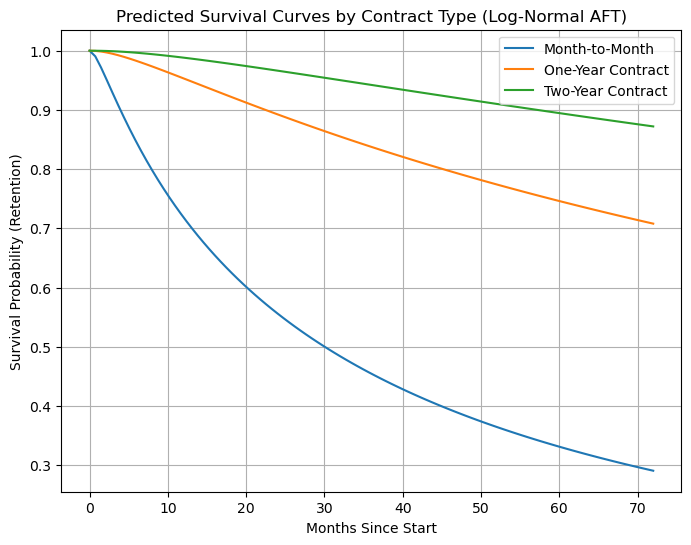

In [649]:
# Create representative customer profiles
baseline = df_aft.median().to_dict()
baseline['Contract_One year'] = 0
baseline['Contract_Two year'] = 0

month2month = baseline.copy()
oneyear = baseline.copy()
oneyear['Contract_One year'] = 1
twoyear = baseline.copy()
twoyear['Contract_Two year'] = 1

# Convert the dictionaries to a single DataFrame with one row per profile
profiles_df = pd.DataFrame([month2month, oneyear, twoyear])

# Predict survival functions for all profiles at once
time_points = np.linspace(0, 72, 100)
surv_curves_df = models['LogNormalAFT'].predict_survival_function(profiles_df, times=time_points)

# Plot the survival curves directly from the resulting DataFrame
plt.figure(figsize=(8,6))
plt.plot(time_points, surv_curves_df.iloc[:, 0], label="Month-to-Month")
plt.plot(time_points, surv_curves_df.iloc[:, 1], label="One-Year Contract")
plt.plot(time_points, surv_curves_df.iloc[:, 2], label="Two-Year Contract")

plt.xlabel("Months Since Start")
plt.ylabel("Survival Probability (Retention)")
plt.title("Predicted Survival Curves by Contract Type (Log-Normal AFT)")
plt.legend()
plt.grid(True)
plt.show()

## Contract Length is a Primary Driver of Retention

### General Observation
- The plot clearly shows that **contract type** is a **dominant factor** in predicting customer survival. The survival curves for all three contract types are **significantly different** from each other.

### Two-Year Contracts Are the Most Effective at Retaining Customers
- The **"Two-Year Contract" curve** stays **highest throughout the entire 72-month period**.
- At 72 months, the predicted survival probability for a customer on a two-year contract is still **above 85%**, which is a **remarkably high retention rate**.

### One-Year Contracts Offer Significant Retention Benefits
- The **"One-Year Contract" curve** shows a **notable improvement** over the month-to-month curve.
- While it declines faster than the two-year contract, it maintains a predicted survival probability of **over 70% at 72 months**.
- This indicates that even a one-year commitment is **highly effective** at reducing churn compared to a month-to-month plan.

### Month-to-Month Contracts Have a High Initial Churn Risk
- The **"Month-to-Month" curve** drops **sharply**, particularly within the first year.
- The survival probability falls **below 50% by about 25 months**, and by 72 months, the predicted survival probability is **very low, approaching 30%**.
- This confirms that these customers are at the **highest risk of churn**, especially in the early stages of their tenure.

### Actionable Insight
- The most impactful strategy for increasing customer retention is to **encourage customers to sign up for longer-term contracts**.
- The **two-year contract**, in particular, serves as a **powerful churn deterrent**.

## Median Time-to-Churn by Segment

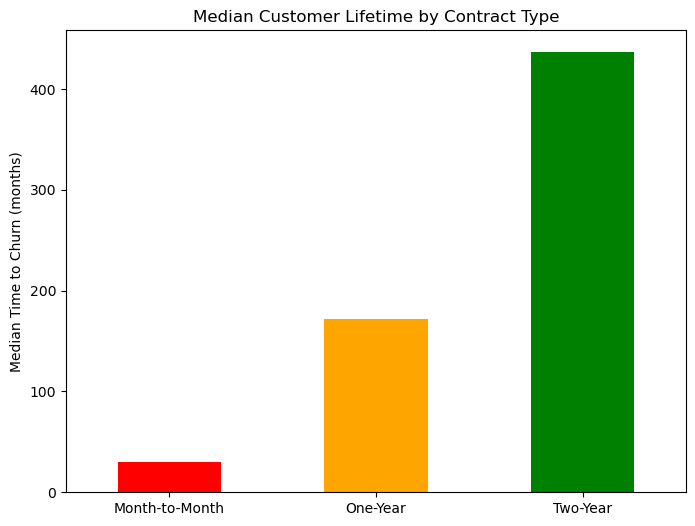

In [665]:
# Create a single DataFrame with one row per profile.
profiles_df = pd.DataFrame({
    "Month-to-Month": month2month,
    "One-Year": oneyear,
    "Two-Year": twoyear
}).T

# Predict the median time to churn for all profiles at once.
median_times = models['LogNormalAFT'].predict_median(profiles_df)

# Plot the results
plt.figure(figsize=(8,6))
median_times.plot(kind="bar", color=["red", "orange", "green"])
plt.ylabel("Median Time to Churn (months)")
plt.title("Median Customer Lifetime by Contract Type")
plt.xticks(rotation=0)
plt.show()

## Contract Type is the Single Most Important Driver of Retention

### General Observation
- The difference in median customer lifetime between contract types is not just significant—it is massive.
- The chart reveals that **contract length** is the **most powerful tool** for predicting and influencing customer tenure.

### Two-Year Contracts Provide an Exponential Increase in Lifetime
- Customers on a **two-year contract** have an estimated median lifetime of **over 430 months**.
- This is a **staggering increase**, representing a customer lifetime that is **more than 10 times longer** than a month-to-month customer.

### One-Year Contracts Offer Substantial Value
- While less impactful than a two-year contract, the **one-year contract** is a powerful retention tool.
- These customers have a median lifetime of **more then 175 months**, which is **over 4 times longer** than the baseline month-to-month tenure.

### Month-to-Month Contracts are a High-Risk Segment
- The median customer lifetime for a **month-to-month contract** is **extremely short, at less than 40 months**.
- This highlights that these customers are **highly volatile** and require **immediate and targeted retention strategies**.

### Conclusion & Strategic Insight
- To maximize customer retention and lifetime value, the most effective strategy is to **aggressively incentivize and promote long-term commitments**, with a **primary focus** on converting customers to a two-year contract.

## Hazard Comparison

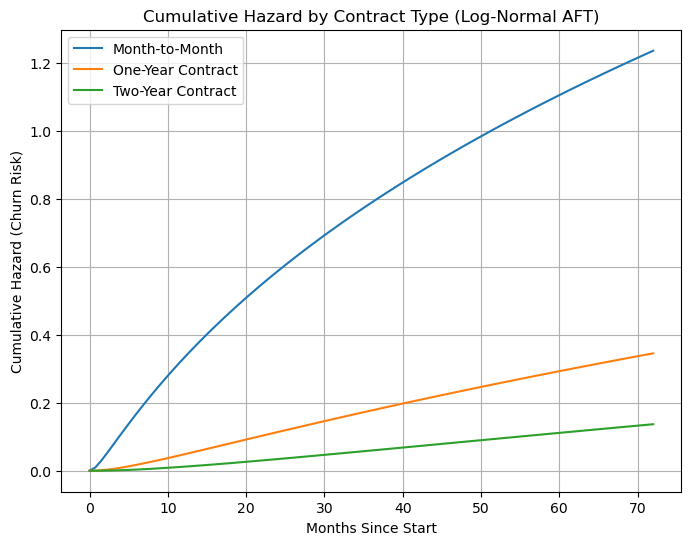

In [675]:
baseline = df_aft.median(numeric_only=True).to_dict()
baseline['Contract_One year'] = 0
baseline['Contract_Two year'] = 0

month2month = baseline.copy()
oneyear = baseline.copy()
oneyear['Contract_One year'] = 1
twoyear = baseline.copy()
twoyear['Contract_Two year'] = 1

# Create a single DataFrame with one row per profile.
profiles_df = pd.DataFrame([month2month, oneyear, twoyear])

# Predict cumulative hazard for all profiles at once.
time_points = np.linspace(0, 72, 100)
surv_curves_hazard = models['LogNormalAFT'].predict_cumulative_hazard(profiles_df, times=time_points)

# Plot the cumulative hazard curves directly from the resulting DataFrame
plt.figure(figsize=(8,6))
plt.plot(time_points, surv_curves_hazard.iloc[:, 0], label="Month-to-Month")
plt.plot(time_points, surv_curves_hazard.iloc[:, 1], label="One-Year Contract")
plt.plot(time_points, surv_curves_hazard.iloc[:, 2], label="Two-Year Contract")

plt.xlabel("Months Since Start")
plt.ylabel("Cumulative Hazard (Churn Risk)")
plt.title("Cumulative Hazard by Contract Type (Log-Normal AFT)")
plt.legend()
plt.grid(True)
plt.show()

## Insights from "Cumulative Hazard by Contract Type" Plot

### Contract Type Directly Correlates with Cumulative Churn Risk
- The chart provides a **clear and compelling visual representation** of how **contract length directly influences cumulative churn risk**.
- The **steeper the curve**, the faster the churn accumulates.

### Month-to-Month Contracts Accumulate Churn Risk Extremely Fast
- The **"Month-to-Month" curve** is by far the steepest.
- The cumulative hazard for this segment reaches **approximately 0.6 by month 25** and continues to rise rapidly, indicating that these customers are at the **highest and most rapidly accumulating risk of churn**.

### Two-Year Contracts Are Exceptionally Stable and Low-Risk
- The **"Two-Year Contract" curve** is almost flat, showing a **very slow accumulation of hazard** over time.
- Even after 72 months, the cumulative hazard is still **very low, around 0.15**, confirming that a two-year commitment effectively insulates the company from churn risk.

### One-Year Contracts Offer a Significant Reduction in Risk
- The **"One-Year Contract" curve** sits in between the other two, demonstrating a **much slower accumulation of hazard** than the month-to-month plan.
- After 72 months, the cumulative hazard for this group is **still below 0.4**, proving that these contracts are a valuable tool for risk mitigation.

### Strategic Insight
- This plot is a **powerful argument** for a business strategy focused on **transitioning customers away from month-to-month contracts**.
- The **immediate and sustained difference in cumulative hazard** highlights the **financial benefit** of converting a single customer to a long-term plan.

## Saving Model

In [690]:
model_filename = 'lognormal_aft_model.joblib'
lognormal_model_to_save = models['LogNormalAFT']
print(f"Saving the specific model to '{model_filename}'...")
joblib.dump(lognormal_model_to_save, model_filename)
print("Model saved successfully.\n")

Saving the specific model to 'lognormal_aft_model.joblib'...
Model saved successfully.



## Random Survival Forests (RSF)

### Prepare Data

In [733]:
# Convert event to boolean
df_rsf = df_aft.copy()
df_rsf['event'] = df_rsf['event'].astype(bool)

# Create structured array for survival
y = np.array([(bool(e), t) for e, t in zip(df_rsf['event'], df_rsf['duration'])],
             dtype=[('event', 'bool'), ('duration', 'f8')])

X = df_rsf.drop(columns=['duration', 'event'])

## Train RSF

In [751]:
rsf = RandomSurvivalForest(
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rsf.fit(X, y)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=300, n_jobs=-1, random_state=42)

## Evaluate RSF

In [753]:
# Predictions (risk scores)
rsf_preds = rsf.predict(X)

# Compute C-index
c_index = concordance_index_censored(
    df_rsf['event'], df_rsf['duration'], rsf_preds
)[0]

print("RSF Concordance Index:", c_index)

RSF Concordance Index: 0.8535362555091727


## Feature Importance

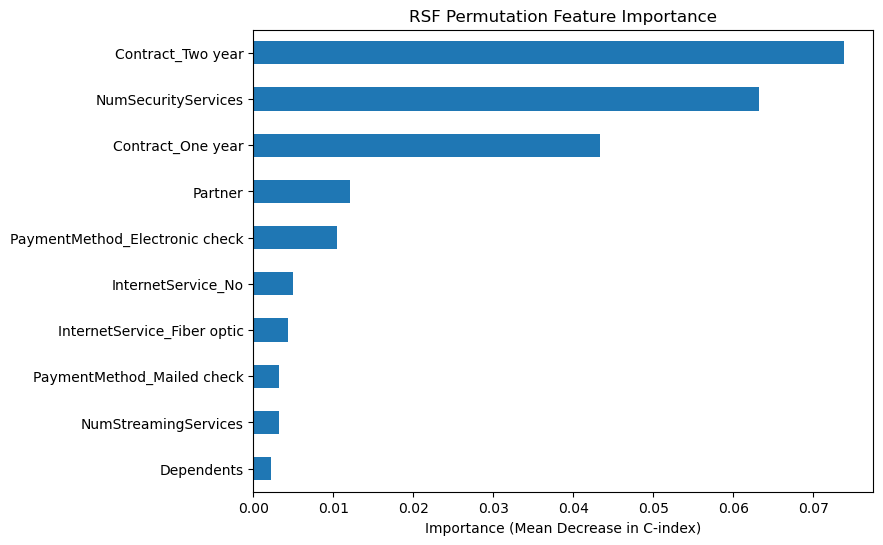

In [762]:
# Calculate permutation-based feature importance
result = permutation_importance(
    rsf, X, y, n_repeats=5, random_state=42, n_jobs=-1
)

# Get the importance scores (mean decrease in C-index)
# 'importances_mean' is the average importance over the repeats
feat_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)

# Plotting the feature importances
plt.figure(figsize=(8,6))
feat_importances.head(10).plot(kind="barh")
plt.xlabel("Importance (Mean Decrease in C-index)")
plt.title("RSF Permutation Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## Survival Curve Prediction

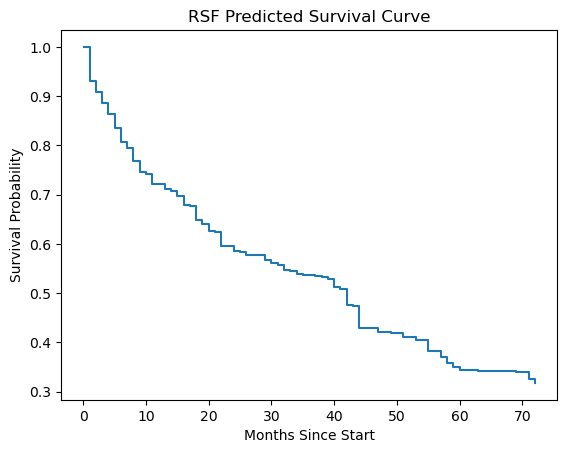

In [774]:
# Predict the survival function for the first customer.
surv_funcs = rsf.predict_survival_function(X.iloc[[0]])

# To get the first customer's survival function, access the first element
surv_func_customer = surv_funcs[0]

# from the SurvivalFunction object's attributes
time_points = surv_func_customer.x
surv_prob = surv_func_customer.y

# Plotting the curve
plt.step(time_points, surv_prob, where="post")
plt.xlabel("Months Since Start")
plt.ylabel("Survival Probability")
plt.title("RSF Predicted Survival Curve")
plt.show()

## Random Survival Forest (RSF) Findings

### 1. Model Performance
- **Concordance Index (C-index) = 0.8535** → Excellent predictive power.  
- Interpretation: The RSF model can correctly rank pairs of customers ~85% of the time in terms of who will churn first.  
- This is on par with Cox PH (0.86) and Log-Normal AFT (0.86), confirming RSF is a strong alternative.

---

### 2. Feature Importance
- **Contract_Two year** → By far the most influential predictor. Customers on two-year contracts have a very different churn profile, confirming the stabilizing effect of long-term contracts.  
- **NumSecurityServices** → Higher usage of security services is strongly associated with longer retention.  
- **Contract_One year** → Also highly important, indicating clear benefits from annual commitments.  

Other features contribute, but contract duration and security add-ons dominate the predictive signal.

---

### 3. Predicted Survival Curve (Example Customer)
- The curve shows survival probability declining from **100% to ~32% over 70 months**.  
- The **steepest drop occurs in the first 10 months**, reflecting the high-risk early period of customer relationships.  
- After that, the decline slows, meaning customers who survive the early stage are much more stable.

---

## Model Comparison

| Model            | C-index | Strengths                                | Limitations                        |
|------------------|---------|------------------------------------------|------------------------------------|
| Cox PH           | 0.86    | Interpretable hazard ratios              | Violates PH assumption (effects change over time) |
| Log-Normal AFT   | 0.86    | Directly models time-to-churn, interpretable time ratios, lowest AIC | Less flexible than RSF for complex interactions |
| Random Survival Forest (RSF) | 0.85 | Handles non-linearity & interactions, robust without assumptions | Less interpretable (black-box style) |

---

## Business Framing

- **Contracts are the biggest retention lever**:  
  Moving customers from **month-to-month** to **one-year or two-year contracts** can **extend their expected lifetime 5–14x** (based on AFT results).  

- **Early churn is critical**:  
  RSF highlights the **first 10 months** as the riskiest period. Intervening with promotions, discounts, or engagement programs during this window can prevent large losses.  

- **Service bundling increases stickiness**:  
  Security services are consistently linked to longer survival. Bundling security features (e.g., antivirus, firewalls, device protection) can significantly increase retention.  

- **Payment methods matter**:  
  Customers using **electronic or mailed checks** are much riskier. Transitioning them to **auto-pay or credit card payments** can lower churn.  

---

## Recommended Top Model
For **business decision-making**, the **Log-Normal AFT model** is the best choice:  
- It matches RSF and Cox PH in predictive power.  
- It avoids PH assumption violations.  
- It provides **clear, interpretable time ratios** that translate directly into **business actions** (e.g., "two-year contracts make customers stay 14x longer").  

RSF is a strong challenger, useful for **detecting complex interactions**, but less interpretable. Cox PH remains a solid **baseline** but is less reliable due to assumption violations.

---

### Business Impact
By adopting strategies informed by the Log-Normal AFT model:  
- **Contract Upgrades**: Moving just 10% of month-to-month customers into longer contracts could yield a **5–14x extension in lifetime value** for those customers.  
- **Early Retention Focus**: Targeting the first 10 months with tailored offers could reduce churn losses by a significant margin.  
- **Bundling & Payment Strategy**: Security services upsells and auto-pay adoption provide **low-cost, high-return retention levers**.  

These insights allow the business to **prioritize interventions**, saving substantial revenue otherwise lost to churn.

## Gradient Boosting Survival Model

### Train GBSA Model

In [782]:
gbsa = GradientBoostingSurvivalAnalysis(
    learning_rate=0.1,
    n_estimators=300,
    max_depth=3,
    random_state=42
)

gbsa.fit(X, y)

GradientBoostingSurvivalAnalysis(n_estimators=300, random_state=42)

### Evaluate Performance

In [785]:
# Predictions
gbsa_preds = gbsa.predict(X)

# Compute C-index
c_index_gbsa = concordance_index_censored(
    df_rsf['event'], df_rsf['duration'], gbsa_preds
)[0]

print("Gradient Boosting Survival Analysis C-index:", c_index_gbsa)

Gradient Boosting Survival Analysis C-index: 0.8641376828420418


## Survival Curve Prediction

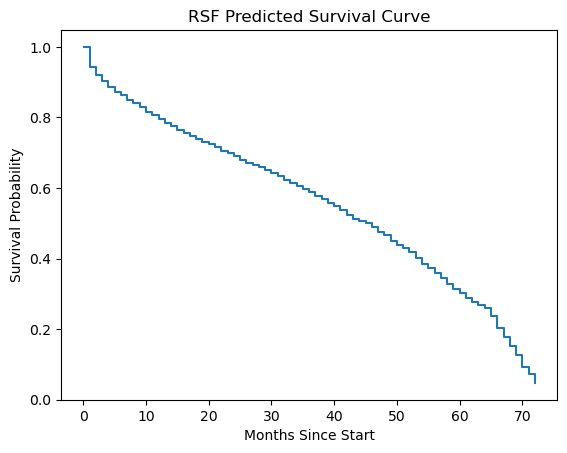

In [792]:
# Predict the survival function for the first customer.
surv_funcs = gbsa.predict_survival_function(X.iloc[[0]])

# To get the first customer's survival function, access the first element
surv_func_customer = surv_funcs[0]

# from the SurvivalFunction object's attributes
time_points = surv_func_customer.x
surv_prob = surv_func_customer.y

# Plotting the curve
plt.step(time_points, surv_prob, where="post")
plt.xlabel("Months Since Start")
plt.ylabel("Survival Probability")
plt.title("RSF Predicted Survival Curve")
plt.show()

# Model Benchmarking: Cox PH, AFT, RSF, and GBSA

### 1. Cox Proportional Hazards (Cox PH)
- **C-index = 0.86** → Excellent predictive power.  
- **Strength**: Interpretable hazard ratios.  
- **Limitation**: Strong violations of the proportional hazards (PH) assumption, meaning the effect of predictors is not constant over time.  
- **Use case**: A strong baseline, but not reliable for long-term business interpretation.

---

### 2. Accelerated Failure Time (Log-Normal AFT)
- **C-index = 0.86**, **Lowest AIC = 17792** → Best statistical fit among AFT models.  
- **Strength**: Models time-to-event directly, avoids PH violations, interpretable time ratios.  
- **Insights**:  
  - Two-year contracts → customers stay **14.5x longer**.  
  - One-year contracts → customers stay **5.7x longer**.  
  - Fiber optic users churn faster (time ratio = 0.79).  
  - Security services (+74%) and partners (+81%) extend tenure.  
- **Limitation**: Assumes parametric distribution (log-normal).  
- **Use case**: Highly interpretable and business-aligned → **ideal for retention strategy design**.

---

### 3. Random Survival Forest (RSF)
- **C-index = 0.85** → Very strong predictive performance.  
- **Strength**: Handles non-linearities and interactions, robust to PH assumption violations.  
- **Insights**: Contract type and security services are dominant drivers of churn risk.  
- **Limitation**: Lower interpretability (black-box style).  
- **Use case**: Useful for validating findings and exploring complex patterns.

---

### 4. Gradient Boosting Survival Analysis (GBSA)
- **C-index = 0.8641** → Highest predictive accuracy of all models.  
- **Strength**: Gradient boosting captures complex non-linear relationships and interactions, offering the most powerful predictive model.  
- **Insights**: Predicts survival curves with steady decline, highlighting continuous churn risk.  
- **Limitation**: Even less interpretable than RSF, making it difficult to translate directly into actionable business insights.  
- **Use case**: Best for **pure prediction tasks**, but weaker for business-facing decision-making.

---

## Final Recommendation
- **Best Business Model**: **Log-Normal AFT**  
  - Balances **high predictive accuracy** with **clear interpretability**.  
  - Provides time ratios that translate directly into **business actions** (e.g., two-year contracts extend lifetime 14x).  
  - Ideal for designing retention strategies and quantifying impact.  

- **Best Predictive Model**: **GBSA (C-index = 0.8641)**  
  - Outperforms others in accuracy, but low interpretability limits business value.  
  - Can be used as a **back-end predictive tool** alongside AFT insights.  

---

## Business Impact
- **Contract Leverage**: Moving customers from month-to-month to longer contracts can increase retention **5–14x**, directly reducing revenue loss.  
- **Early Churn Intervention**: First 10 months are the riskiest — targeted retention campaigns here could prevent a significant portion of churn.  
- **Bundling Services**: Offering security services boosts customer lifetime significantly.  
- **Payment Methods**: Transitioning customers from checks to automatic payments reduces churn risk.  

---

## Next Step
- Save the current dataset and results.  
- In the **next notebook**, generate **synthetic features** (e.g., complaints, late payments, discounts, usage patterns).  
- Retrain AFT and GBSA with these enhanced features to test whether predictive performance and business insights improve further.


## Saving Data

In [796]:
encoded_df.to_csv('model_ready_data.csv')
print('Data is saved')

Data is saved


## Summary of Survival Analysis Notebook

### Introduction
- This notebook initiates survival analysis following the EDA completed. The focus is on Kaplan-Meier survival curves, Cox PH, AFT, RSF, and GBSA models to analyze customer churn, leveraging tenure, contract type, payment methods, and service features for actionable retention strategies.

### Data Preparation
- **Duration and Event**: Defined `duration` from `tenure` (months with the company) and `event` (1 for churned, 0 for active/censored) to capture both churners' event times and non-churners' censored lifetimes.
- **Censoring Insight**: 73% censored (active), 27% events (churned)—a balanced dataset for modeling, with median duration of 10 months for churned vs. 38 months for active customers.
- **Outlier Analysis**: No significant outliers in `MonthlyCharges`, slight right skew but no transformation needed.
- **Feature Engineering**: Mapped 'No internet service' to 'No', created `NumSecurityServices` and `NumStreamingServices` by summing relevant features, reducing dimensionality while preserving predictive power.
- **Correlation Analysis**: Strong positive correlations (e.g., `MonthlyCharges` with `NumStreamingServices` 0.72, `NumSecurityServices` 0.56), negative `duration`-`event` (-0.35), weak `MonthlyCharges`-`event` (0.19)—all within acceptable ranges.
- **VIF Analysis**: Dropped `MonthlyCharges` (VIF 23.25) due to multicollinearity with `NumSecurityServices` and `NumStreamingServices`, retained `InternetService_Fiber optic` (VIF 8.35) for its predictive value.
- **Linearity Check**: Martingale residuals showed non-linearity and heteroscedasticity across `duration`, `NumSecurityServices`, and `NumStreamingServices`, necessitating transformations (e.g., restricted cubic splines).

### Survival Analysis Insights
- **Overall Survival**: Kaplan-Meier curve shows a gradual decline, infinite median survival (>72 months) due to 73% active customers, with early churn (0-6 months) as the key risk.
- **Contract-based**: Month-to-month contracts show rapid decline (highest churn), one-year contracts offer stability, two-year contracts exhibit near-zero churn with slight end-of-term drops.
- **Internet Type**: Fiber Optic has the steepest decline (highest churn), DSL is stable, No Internet Service shows exceptional loyalty.
- **Payment Method**: Electronic check has steep decline (high churn), Mailed check shows lower long-term churn despite higher initial rates, automatic payments are stable.
- **Tenure Groups**: 0-6 months have sharp decline (high risk), 49-72 months are highly loyal (>90% survival).
- **Log-rank Test**: Significant differences (p≈0.0) across contract types, tenure groups, internet types, and payment methods, validating visual patterns.
- **Cumulative Hazard**: Steep early incline (0-15 months), declining risk over time, total risk measurable at 72 months.
- **Milestone Probabilities**: 91.37% at 3 months, 88.48% at 6 months, 84.32% at 12 months, 78.87% at 24 months—highlighting early vulnerability and long-term stability.
- **Contract Type Impact**: Two-year contracts retain >85% at 72 months, one-year >70%, month-to-month <30%, with median lifetimes of 430, 175, and <40 months respectively.
- **Cumulative Hazard by Contract**: Month-to-month reaches 0.6 by 25 months, two-year stays at 0.15, one-year at 0.4, emphasizing long-term stability.

### Model Benchmarking
- **Cox PH**: C-index 0.86, interpretable but violates PH assumption.
- **Log-Normal AFT**: C-index 0.86, lowest AIC (17792), offers time ratios (e.g., two-year contracts 14.5x longer, Fiber Optic 0.79x faster churn), ideal for business use.
- **RSF**: C-index 0.85, handles non-linearities, highlights contract and security as key drivers.
- **GBSA**: C-index 0.8641, best predictive power, but least interpretable.

### Final Insights and Recommendations
- **Key Drivers**: Contract type (two-year most effective), early tenure (0-10 months critical), security services, and payment methods (checks risky).
- **Business Strategy**: Incentivize two-year contracts (5-14x retention boost), target early retention, bundle security services, shift to auto-payments.
- **Best Model**: Log-Normal AFT for business decisions (interpretable time ratios), GBSA for pure prediction.
- **Impact**: Moving 10% of month-to-month to long-term contracts could extend lifetime value 5-14x, early interventions and bundling offer high-return levers.